In [2]:
import os
import pandas as pd
import numpy as np
import glob
import json
import re
import logging
from pathlib import Path

import nibabel 
import nilearn

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import fdr_threshold,threshold_stats_img
from nilearn import image
from nilearn.image import mean_img, new_img_like
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_anat, plot_img, plot_roi
from nilearn.reporting import get_clusters_table

from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from bids.layout import parse_file_entities

import matplotlib.pyplot as plt
import tracemalloc
import concurrent.futures

In [ ]:
events_path_pattern = f'/om/project/voice/bids/data/sub-voice*/ses-*/func/*events.tsv'
pop_events = find_populated_events(events_path_pattern)
count_pop_events = pop_events.groupby('task').populated.value_counts()

valid_runs = pop_events.events_file[pop_events.populated == True]
parsed_valid_runs = [parse_file_entities(vr) for vr in valid_runs]

subjects_excluded = ['voice997', 'voice897','voice863'] #for some reason these one is not in the fmriprep output
parsed_valid_runs = [pvr for pvr in parsed_valid_runs if pvr['subject'] not in subjects_excluded]

len(parsed_valid_runs)

In [ ]:
# sparse = True

# models = pd.DataFrame([run_first_level_model(pvr['subject'],
#                        pvr['task'],
#                        pvr['session'],
#                        int(pvr['run']),
#                        sparse = sparse) 
#  for pvr in parsed_valid_runs if pvr['task'] == 'pataka'], 
#                       columns= ['fitted_glm', 'nifti', 'events', 'fails'])

# models.to_pickle("pataka_model_masked.pkl")

In [14]:
#all_models = pd.read_pickle("models.pkl") #includes the ones that failed sparse resampling

all_models = pd.read_pickle("pataka_model_masked.pkl") #includes the ones that failed sparse resampling
models = all_models[all_models.fails.isnull()].drop(columns='fails').reset_index() #drop errors and reset index

#have to do p[0] since the events column is a list with one item just because of nipype and a bug
bids_params = pd.DataFrame([parse_file_entities(p[0]) for p in models.events]).drop(['suffix', 'datatype', 'extension'], axis=1)
models = pd.concat([models, bids_params], axis =1)

#store the identity of the ones that failed sparse resampling
fails = [parse_file_entities(p[0]) for p in all_models.events[-all_models.fails.isnull()]]

train = models[models.run == 1] #fROI design with run 1

#drop runs after testing. 
# 854 nwr only had 4 or so entries in the events file
train = train[~((train.subject == 'voice854') & (train.task == 'nwr'))]

test = models[models.run.isin([2,3])] #test currently run 2 and 3. Need to determine why only some have run 3

#MNI brain we are using. Change if different
template = '../../derivatives/templates/tpl-MNI152NLin6Asym_res-02_T1w.nii.gz' 

#task_list = ['nwr', 'emosent', 'pataka', 'vowel'] #pitchsent and pitchnw don't have speech >silent
task_list = ['pataka']

#sample 5 runs from each task that has speech > silent contrast to look at thresholds
#design_df = train[train.task.isin(task_list)].groupby('task').sample(10, random_state=42)
design_df = train[train.task.isin(task_list)]

#code for troubleshooting vowel task

#design_vowel_df = train[train.task == 'vowel']
# parsed_valid_runs = [pvr for pvr in parsed_valid_runs if pvr['task'] == 'vowel']
# parsed_valid_runs = [pvr for pvr in parsed_valid_runs if int(pvr['run']) == 1]

#code that (theoretically) does FDR 0.05 on the data and saves the thresholded output
# Generate z-scored data as FDR wants statistic data input
#could do cluster size threshold but did not

thresh_fdr_05 = []

for rows in design_df.itertuples(index=False):

    contrast = create_contrast(rows.fitted_glm.design_matrices_[0],rows.task)
    zmap = create_zmap(rows.fitted_glm,contrast)
    
    alpha = 0.05
    cluster_threshold = 0
    fdr_map = threshold_stats_img(zmap, height_control='fdr', alpha=alpha, cluster_threshold=cluster_threshold)
    
    binarized = np.where(fdr_map[0].get_fdata()!= 0, 1, 0)
    
    thresh_fdr_05.append(binarized)

design_df['thresh_fdr_05'] = thresh_fdr_05

#create raw overlay pool
pool = design_df.thresh_fdr_05.sum()
pool_img = new_img_like(template, pool)



/om2/user/rfbrito/miniconda/envs/imaging/lib/python3.11/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.86887043409169. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "
/om2/user/rfbrito/miniconda/envs/imaging/lib/python3.11/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.681829050904493. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "
/tmp/ipykernel_113570/1552144775.py:60: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  pool_img = new_img_like(template, pool)


In [30]:
#threshold pool based on some % of subjects
cluster_threshold = int(0.3 * design_df.shape[0]) #exclude voxels with <10% of subjects significant

pool_thresh = (pool >= cluster_threshold) * pool
pool_thresh_img = new_img_like(template, pool_thresh)


/tmp/ipykernel_113570/2954295708.py:5: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  pool_thresh_img = new_img_like(template, pool_thresh)


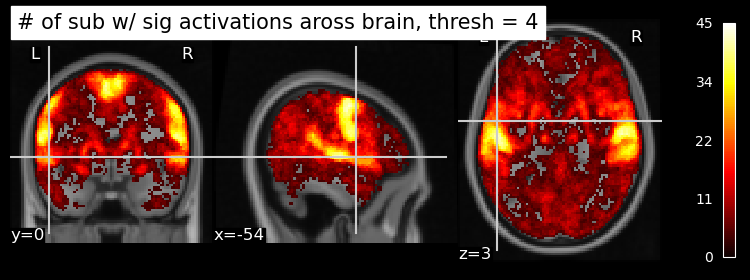

In [26]:
#LH motor coordinates
coord = [-54,0,3]

#cerebellum
#coord = [-4,-60,-26]

# plot_stat_map(pool_img, bg_img=template,cut_coords=coord,
#               threshold = 15,
#               display_mode='ortho', 
#               black_bg=True,
#               title=f'# of sub w/ sig activations aross brain, thresh')

plot_stat_map(pool_thresh_img, bg_img=template,cut_coords=coord,
              display_mode='ortho', 
              black_bg=True,
              title=f'# of sub w/ sig activations aross brain, thresh = {cluster_threshold}')

plt.show()

In [32]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(pool_thresh)
coords = peak_local_max(distance, labels=pool_thresh)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=pool_thresh)

labels_img = new_img_like(template, labels)


In [35]:
markers_img = new_img_like(template, markers)

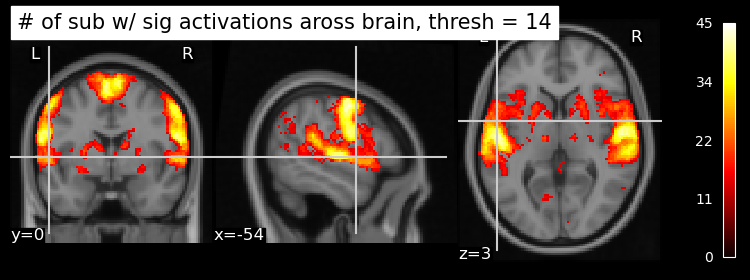

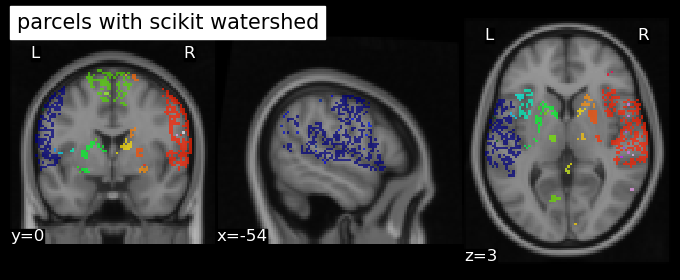

In [36]:
#LH motor coordinates
coord = [-54,0,3]

#cerebellum
#coord = [-4,-60,-26]

plot_stat_map(pool_thresh_img, bg_img=template,cut_coords=coord,
              display_mode='ortho', 
              black_bg=True,
              title=f'# of sub w/ sig activations aross brain, thresh = {cluster_threshold}')

# plot_stat_map(parcels_img , bg_img=template,cut_coords=coord,
#               display_mode='ortho', #cmap = 'viridis',
#               black_bg=True,
#               title=f'parcels based on spm-ss code')

plot_roi(markers_img, bg_img=template,cut_coords=coord,
              display_mode='ortho',
              black_bg=True, draw_cross=False,
              title=f'parcels with scikit watershed')

plt.show()

In [224]:
mask = np.where(labels>0, 1,0)
mask_img = new_img_like(template, mask)

/tmp/ipykernel_5177/3729272117.py:2: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  mask_img = new_img_like(template, mask)


In [26]:
#code from testing Ev's watershed code in matlab
#from scipy.io import savemat, loadmat

# mat = {'A':pool_thresh}
# savemat('test_pool_masked', mat)

# matlab_labels = loadmat('watershed_masked.mat')['D']
# matlab_img = new_img_like(template, matlab_labels)

In [188]:
parcels = watershed(pool_thresh)

#bin_parcels = np.where(parcels>1, 1, 0)
#parcels_img = new_img_like(template, bin_parcels)
parcels_img = new_img_like(template, parcels)


#calculate size of each parcel by finding count of each unique label value
# parcel_df = pd.DataFrame(np.transpose(
#                                 np.unique(parcels[parcels>1], return_counts=True)), 
#                                   columns=['label', 'voxel_count'])

parcel_df = pd.DataFrame(np.transpose(
                                np.unique(labels, return_counts=True)), 
                                  columns=['label', 'voxel_count'])




In [191]:
peak = []
#low = []
for l in parcel_df.label:
    loc = np.argwhere(labels == l)    
    peak.append(np.max([pool_thresh[ii[0],ii[1],ii[2]] for ii in loc]))
    #low.append(np.min([pool_thresh[ii[0],ii[1],ii[2]] for ii in loc]))

parcel_df['peak'] = peak
#parcel_df['low'] = low

Text(0, 0.5, 'peak of ridge')

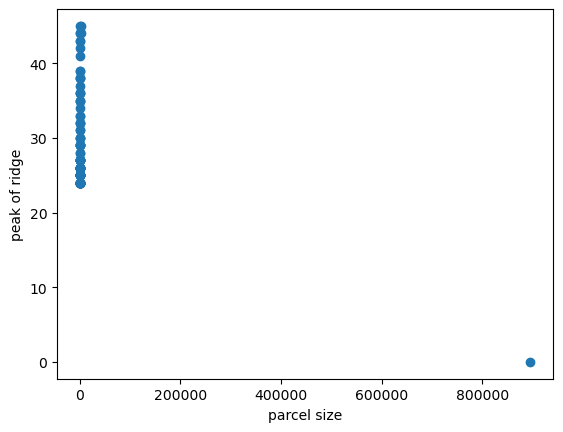

In [192]:
plt.scatter(parcel_df.voxel_count, parcel_df.peak)
#plt.axhline(y=0.7 * design_df.shape[0], color='k', linestyle='-')
#plt.axvline(x= 9 , color='k', linestyle='-')
plt.xlabel('parcel size')
plt.ylabel('peak of ridge')

In [217]:
labels_img

In [212]:
toy = parse_file_entities(design_df.nifti.iloc[0])

In [225]:
fitted_glm, nifti, events, fails = run_first_level_model(toy['subject'],
                                                         toy['task'],
                                                         toy['session'],
                                                         int(toy['run']),
                                                         mask = mask_img,
                                                         sparse = sparse)

230309-19:34:06,444 nipype.interface INFO:
	 Setting dt = 64 ms

230309-19:34:06,448 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0135
230309-19:34:06,449 nipype.interface INFO:
	 reg_scale: 74.2276
230309-19:34:06,460 nipype.interface INFO:
	 Setting dt = 64 ms

230309-19:34:06,464 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0135
230309-19:34:06,465 nipype.interface INFO:
	 reg_scale: 74.2276
230309-19:34:06,476 nipype.interface INFO:
	 Setting dt = 64 ms

230309-19:34:06,479 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0135
230309-19:34:06,480 nipype.interface INFO:
	 reg_scale: 74.2276
230309-19:34:06,492 nipype.interface INFO:
	 Setting dt = 64 ms

230309-19:34:06,495 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0135
230309-19:34:06,496 nipype.interface INFO:
	 reg_scale: 74.2276


In [ ]:
contrast = create_contrast(fitted_glm.design_matrices_[0],toy['task'])
zmap = create_zmap(fitted_glm,contrast)

# alpha = 0.05
# cluster_threshold = 0
# fdr_map = threshold_stats_img(zmap, height_control='fdr', alpha=alpha, cluster_threshold=cluster_threshold)

#cut_coords=coord,

plot_stat_map(zmap, bg_img=template,cut_coords=coord,
                  display_mode='ortho', 
                  black_bg=True,
                  title=f'test')
plt.show()

In [199]:
# from scipy.ndimage import label

# labels_new, n_labels = label(labels)




In [202]:
from nilearn.maskers import NiftiLabelsMasker

labels_new_img = new_img_like(template, labels_new)

masker = NiftiLabelsMasker(
    labels_new_img, resampling_target=None, standardize=False, detrend=False
)
# After initialization of masker object, we call fit() for preparing labels_img
# data according to given parameters
masker.fit()


NiftiLabelsMasker(labels_img=<nibabel.nifti1.Nifti1Image object at 0x2abfdf71c410>,
                  resampling_target=None)

'../../derivatives/fmriprep/sub-voice884/ses-1/func/sub-voice884_ses-1_task-pataka_run-1_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz'

In [207]:
tmp = masker.transform(design_df.nifti.iloc[0])

In [208]:
tmp.shape

(207, 30)

In [51]:
parcels.shape

(91, 109, 91)

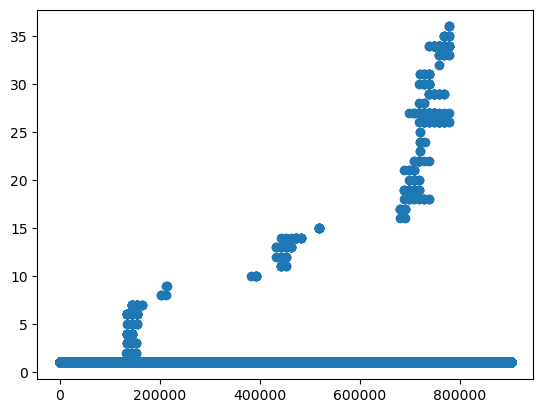

In [43]:
plt.scatter(np.arange(parcels.flatten().shape[0]), parcels.flatten())

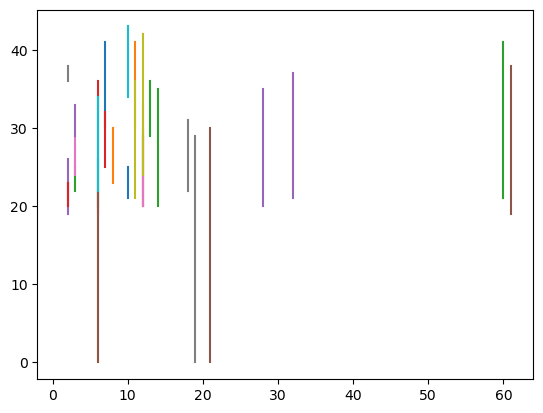

In [85]:
vc = np.transpose([(v, v) for v in parcel_df.voxel_count])
lin = np.transpose([(h,l) for h,l in zip(parcel_df.high, parcel_df.low)])
plt.plot(vc,lin)

In [107]:
loc

array([[14, 38, 38],
       [14, 38, 39],
       [14, 38, 40],
       [14, 39, 39],
       [14, 39, 40],
       [14, 39, 41],
       [14, 39, 42],
       [15, 38, 39],
       [15, 39, 39],
       [15, 39, 40]])

13.2

In [103]:
pool_thresh[14,38,38]

11

In [98]:
type(loc)

tuple

(0.0, 20000.0)

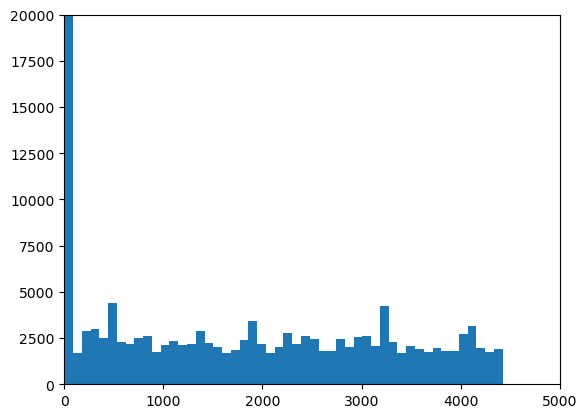

In [76]:
plt.hist(parcels.flatten(), bins=50)
plt.xlim([0, 5000])
plt.ylim([0, 20000])

In [61]:
parcels[40,50,:]

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
       1738, 1738, 1826,    1,    1,    1,    1,    1,    1,    1, 1675,
       1675, 1675, 1675, 1675, 1675,    1,    1,    1,    1,    1,    1,
          1,    1, 1823, 1823, 1741, 1741, 1741, 1741, 1739, 1821, 1824,
       1825, 1825, 1825, 1822, 1822, 1822, 1822, 1822,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1], dtype=int32)

(0.0, 1000.0)

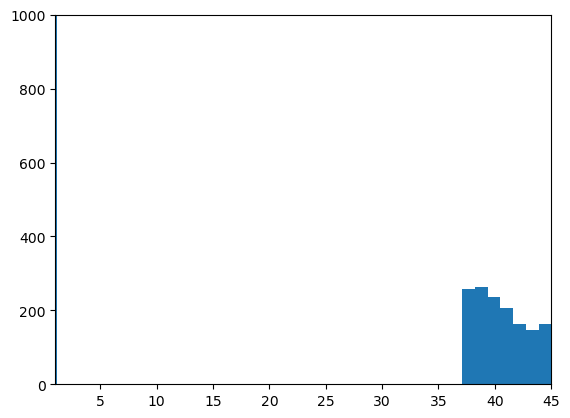

In [248]:
plt.hist(pool_thresh.flatten(), bins=40)
plt.xlim([1,45])
plt.ylim([0,1000])

In [52]:
#This method forces me to pre-supposed a threshold but I don't know that so Watershed it is

# cluster_threshold = int(0.8 * design_df.shape[0])
# parcels = get_clusters_table(pool_img,stat_threshold=cluster_threshold)
# fil = parcels["Cluster Size (mm3)"] != ''
# dfnew = parcels[fil]

# plt.scatter(dfnew['Cluster Size (mm3)'], dfnew['Peak Stat'])

In [ ]:
# This one is also dumb because I have to know number of parcels ahead of time
# from nilearn.regions import Parcellations
# ward = Parcellations(
#     method="ward",
#     n_parcels=40,
#     standardize=False, #smoothing_fwhm=2.0,
#     memory="nilearn_cache",
#     memory_level=1,
#     verbose=1,
# )
# # Call fit on functional dataset: single subject (less samples).
# ward.fit(pool_thresh_img)

# ward_labels_img = ward.labels_img_
# plot_roi(
#     ward_labels_img, title="Ward parcellation", display_mode="ortho",
#     cut_coords=coord,
# )

# plt.show()

In [84]:
# from skimage.feature import peak_local_max
# local_max = peak_local_max(pool, min_distance=5)
# local_max = local_max[0:20]

# maxes = np.zeros(pool.shape)

# for lm in local_max:
#     maxes[lm[0],lm[1],lm[2]] = 1


#lm = new_img_like(template, maxes)

In [185]:
# from scipy import ndimage as ndi

In [191]:
# from skimage.feature import peak_local_max

# coords = peak_local_max(pool)
# mask = np.zeros(pool.shape, dtype=bool)
# mask[tuple(coords.T)] = True
# markers, _ = ndi.label(mask)
# labels = watershed(pool, markers)

/tmp/ipykernel_37092/4289476330.py:2: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  w = new_img_like(template, pool_thresh)


In [ ]:
#parcels_sub = pool * (parcels/parcels.max())

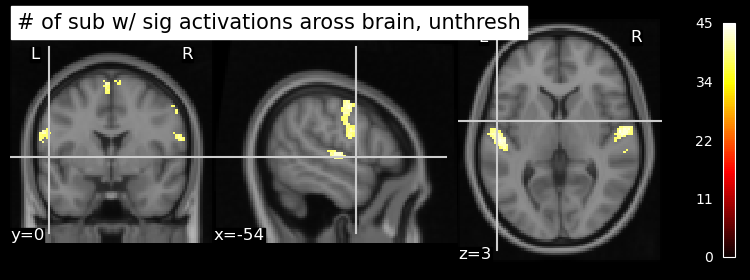

In [250]:
#w = new_img_like(template, watershed(-pool))
w = new_img_like(template, pool_thresh)

plot_stat_map(w , bg_img=template,cut_coords=coord,
              display_mode='ortho', #cmap = 'viridis',
              black_bg=True,
              title=f'# of sub w/ sig activations aross brain, unthresh')

plt.show()

In [23]:
a = fdr_map[0].get_fdata()

In [35]:
a[10,48,52]

3.283144509981697

In [34]:
np.where((a != 0))

(array([10, 10, 10, ..., 80, 81, 81]),
 array([48, 53, 53, ..., 56, 51, 52]),
 array([52, 38, 39, ..., 38, 41, 41]))

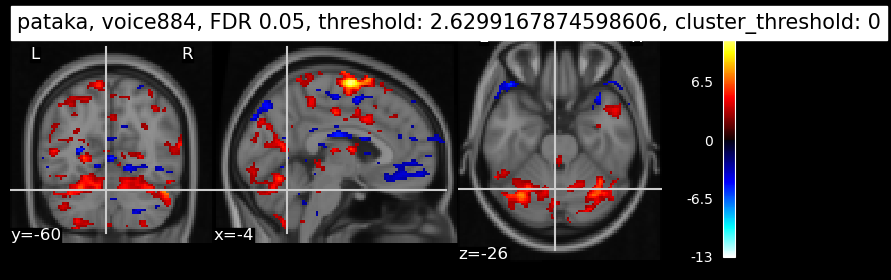

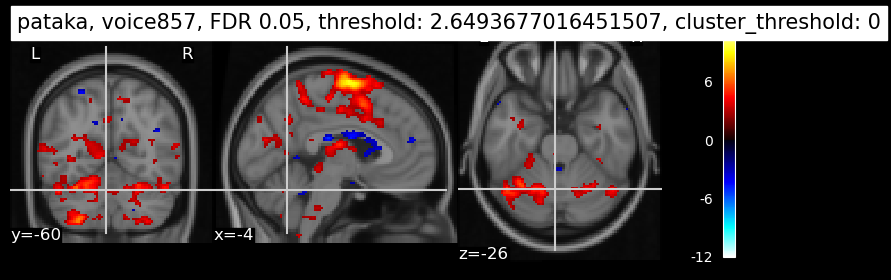

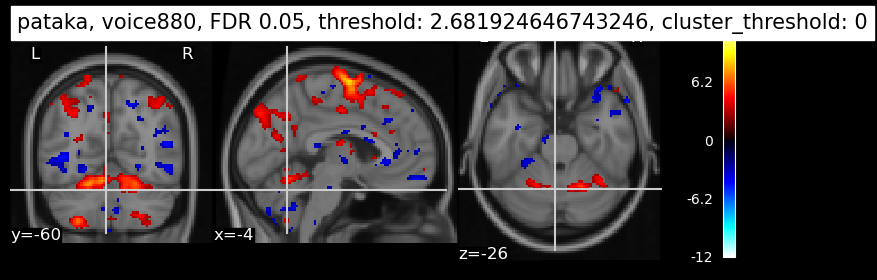

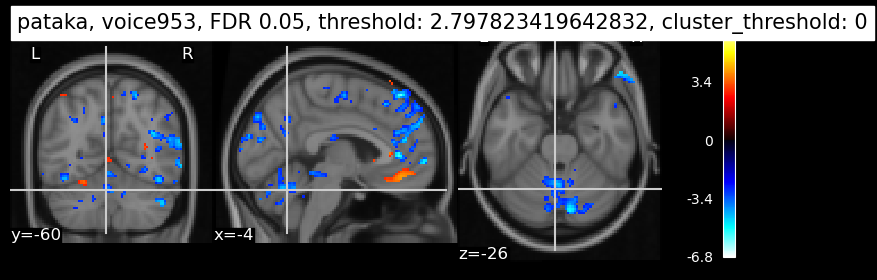

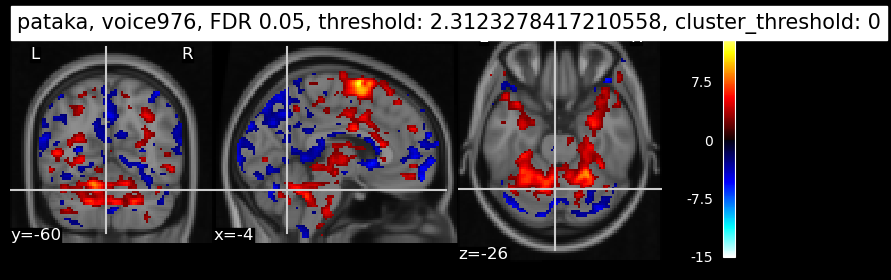

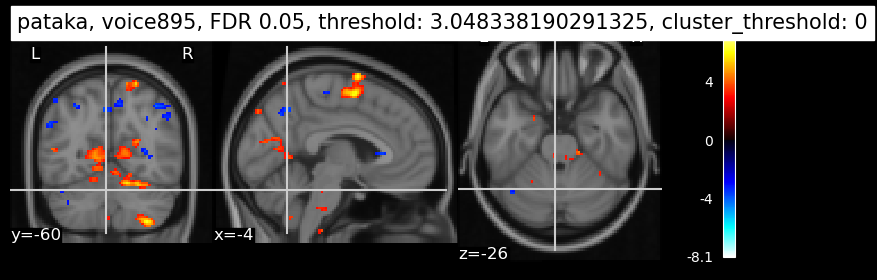

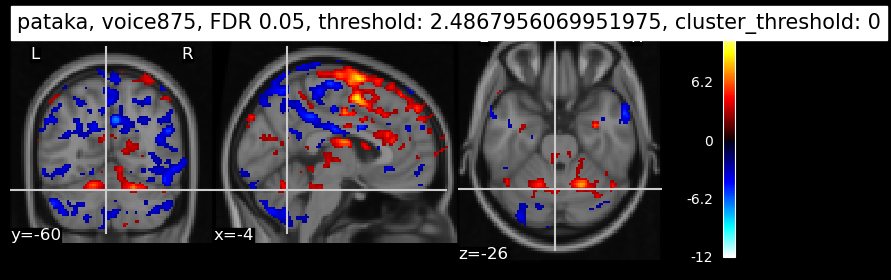

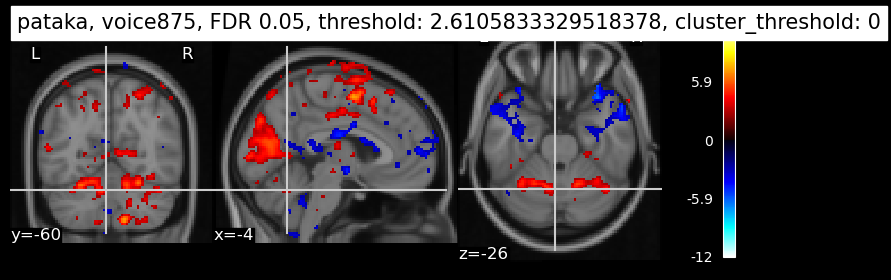

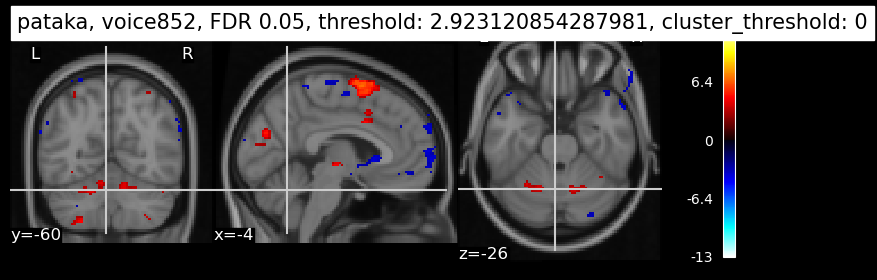

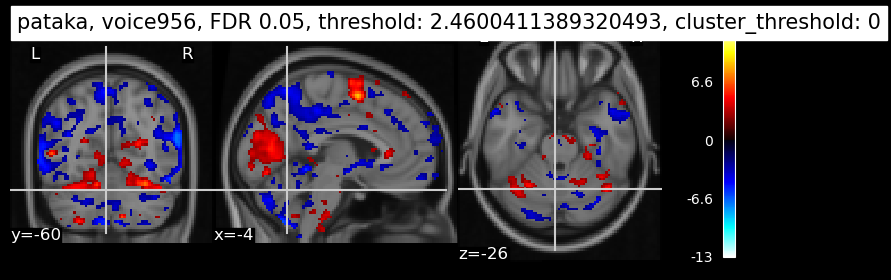

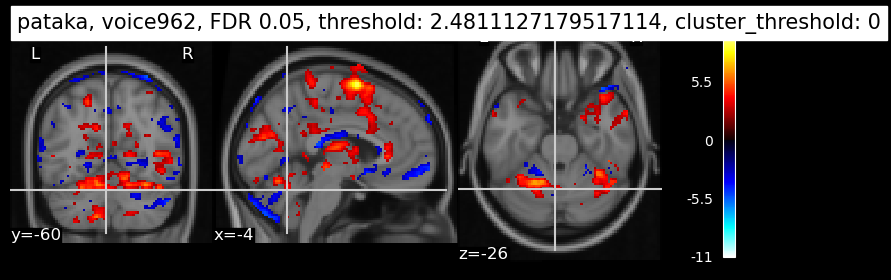

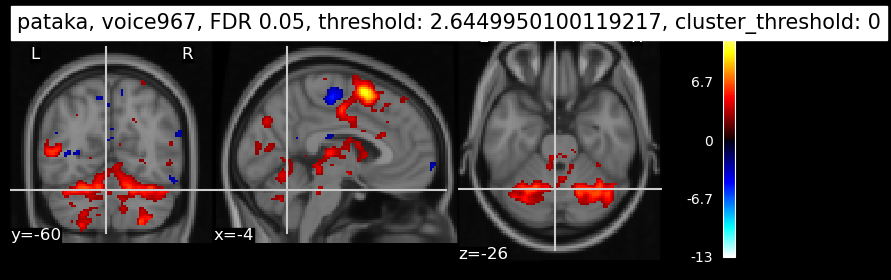

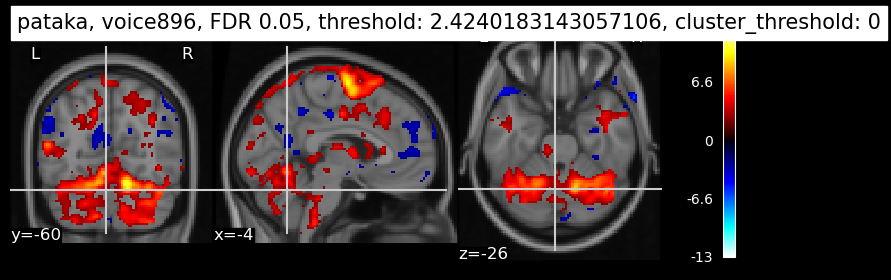

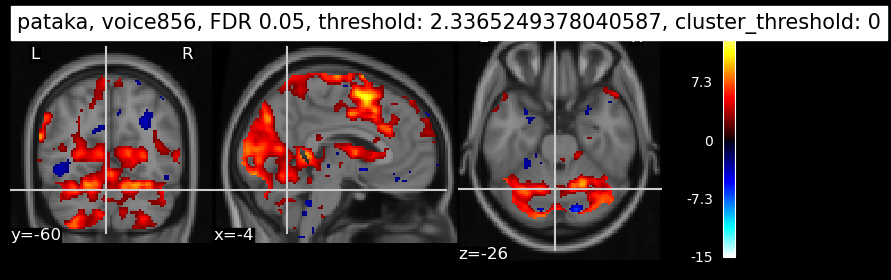

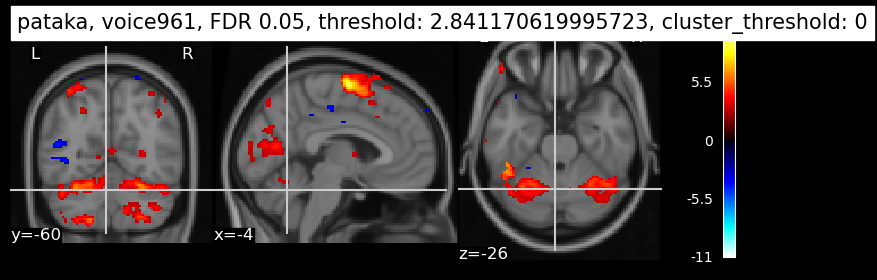

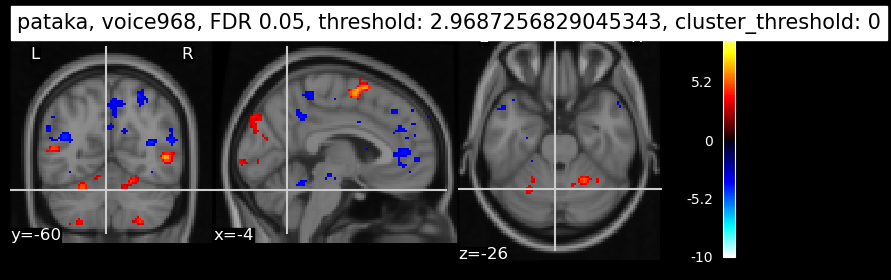

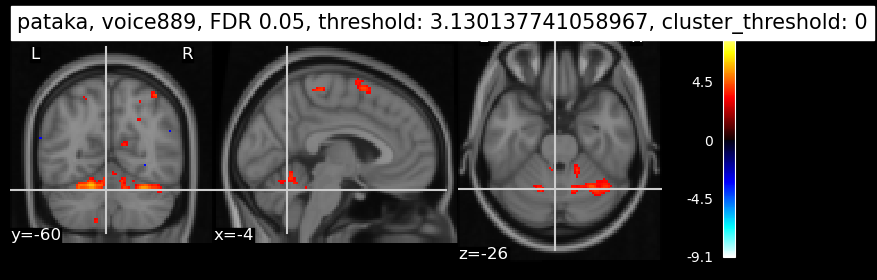

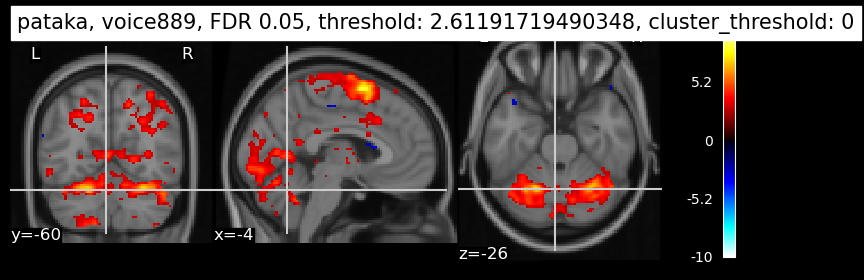

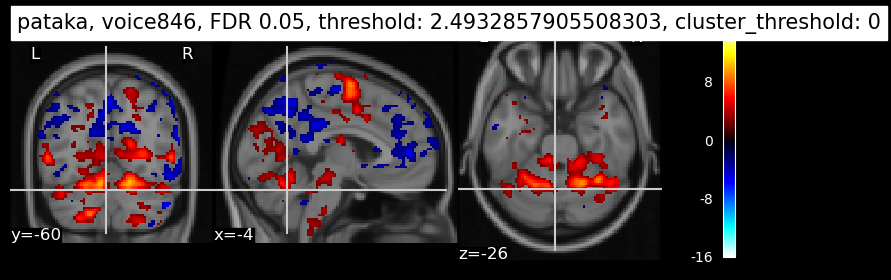

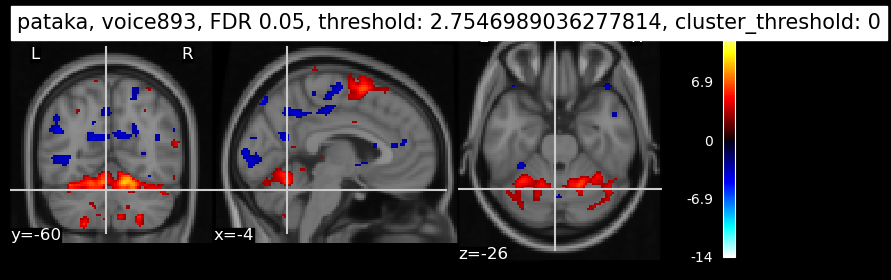

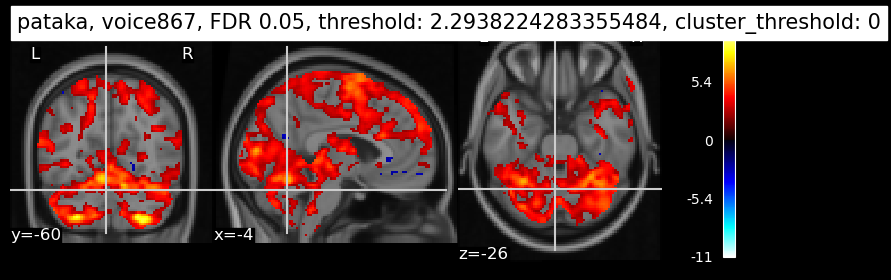

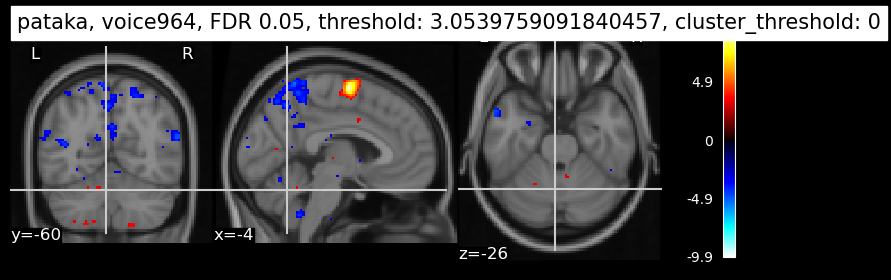

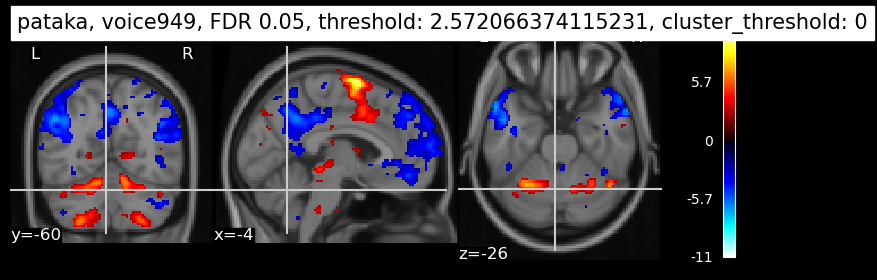

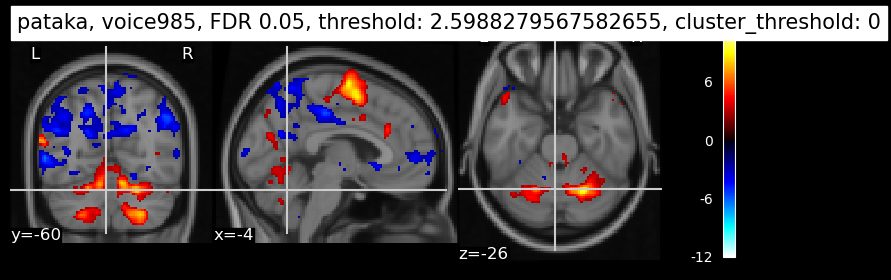

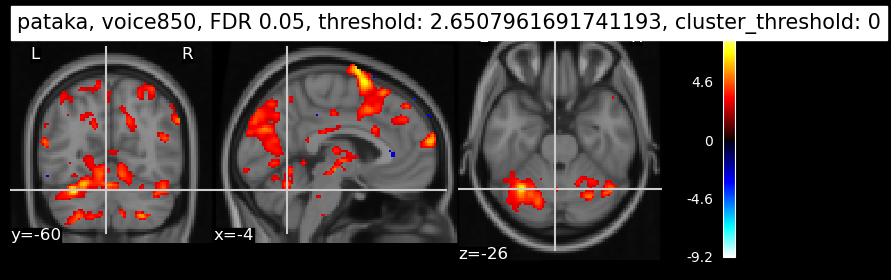

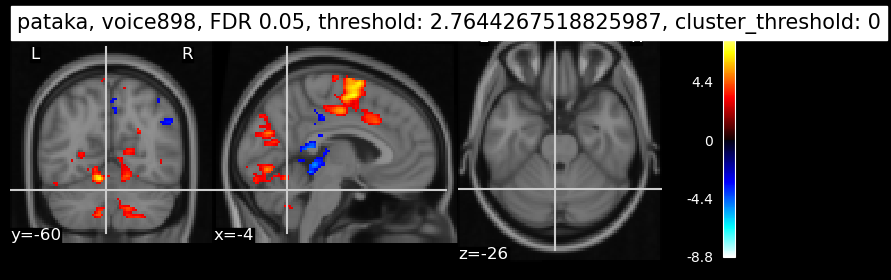

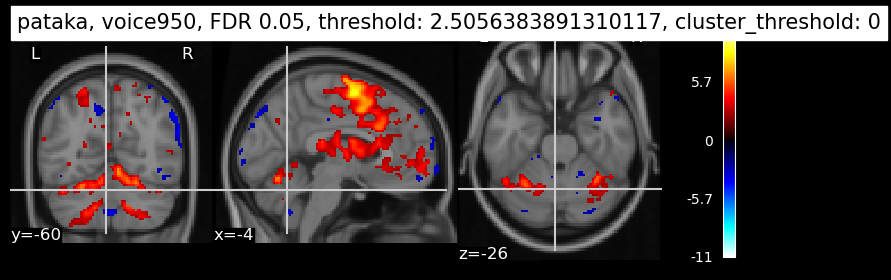

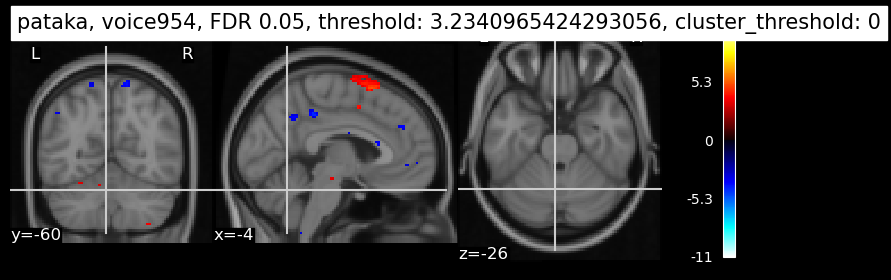

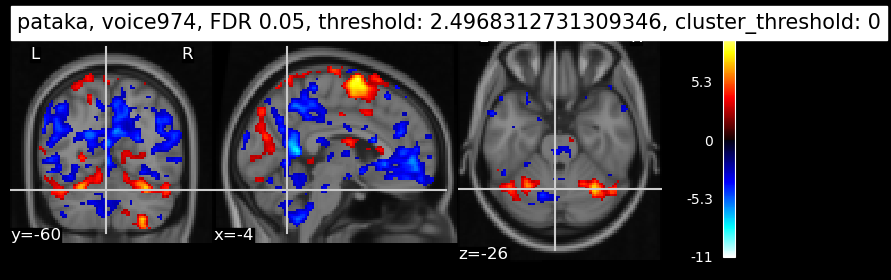

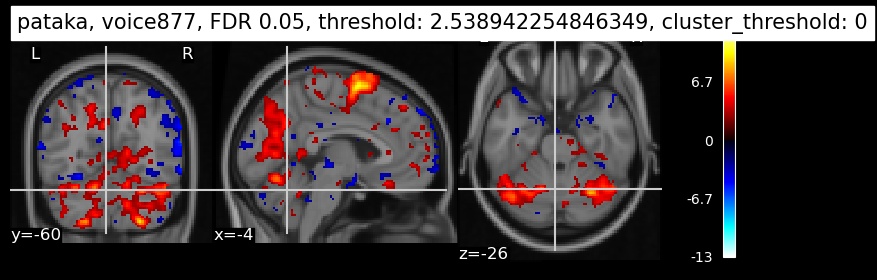

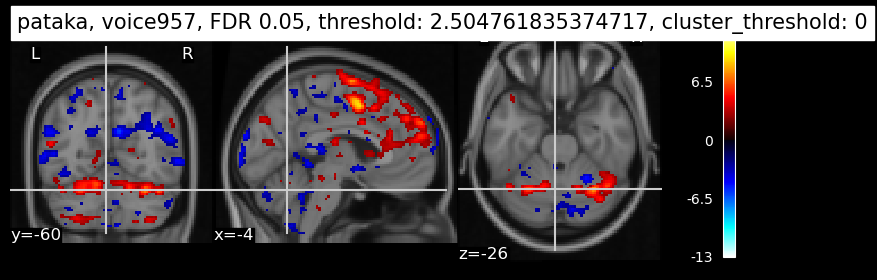

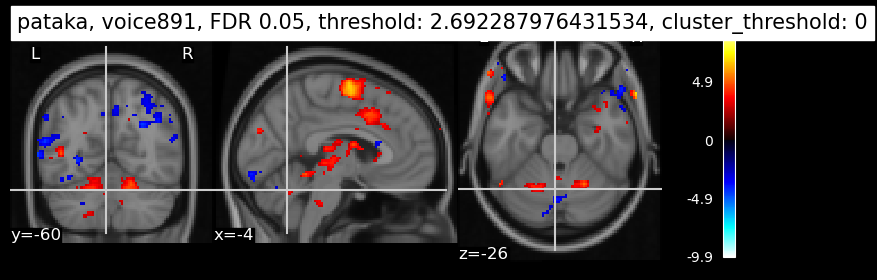

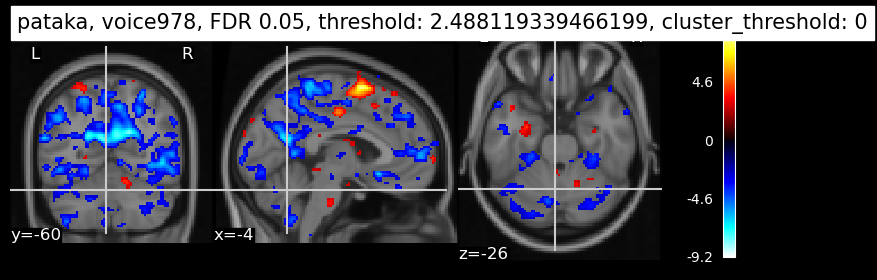

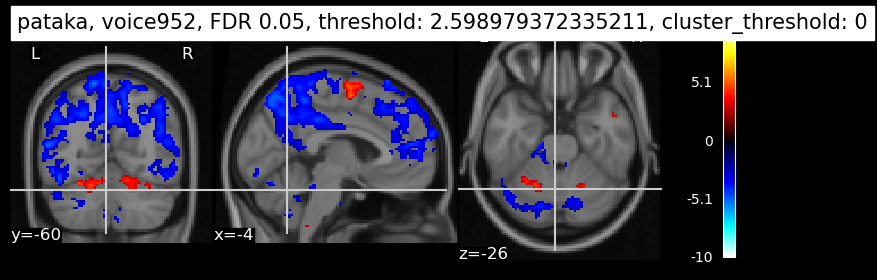

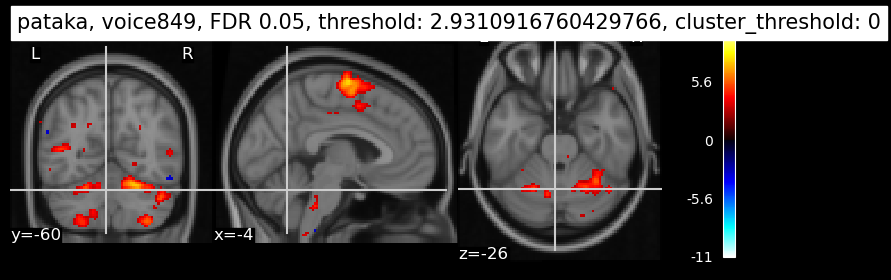

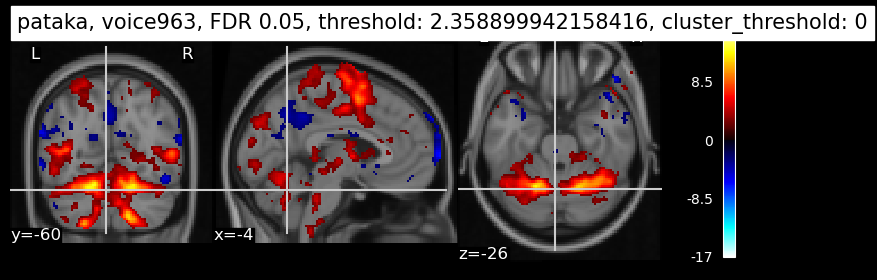

/om2/user/rfbrito/miniconda/envs/imaging/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


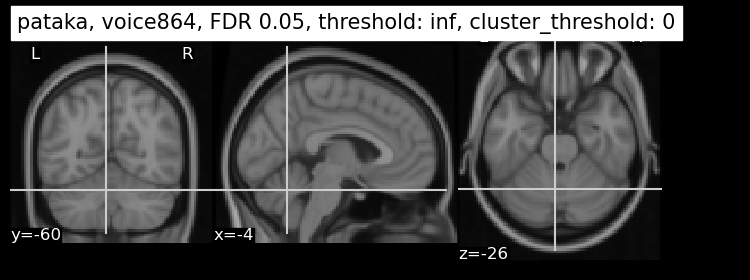

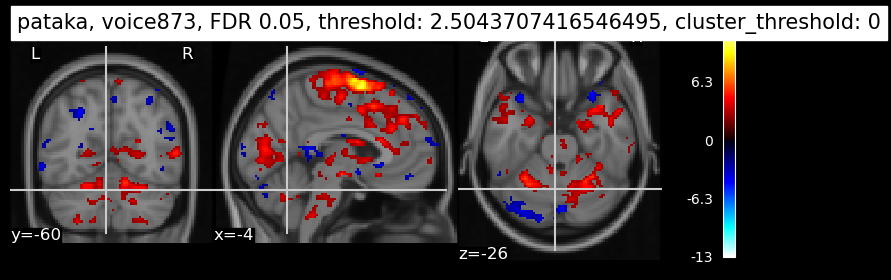

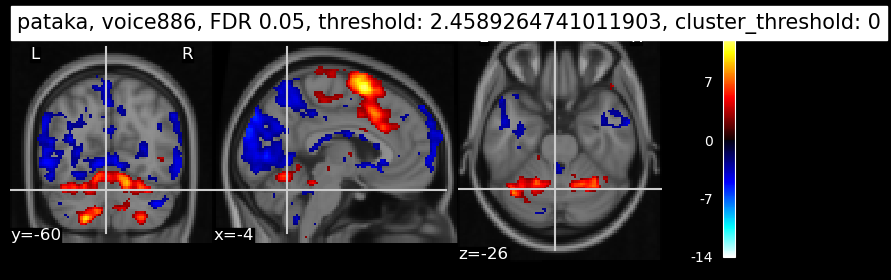

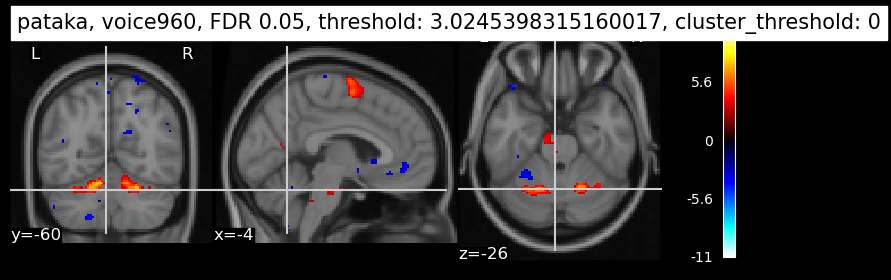

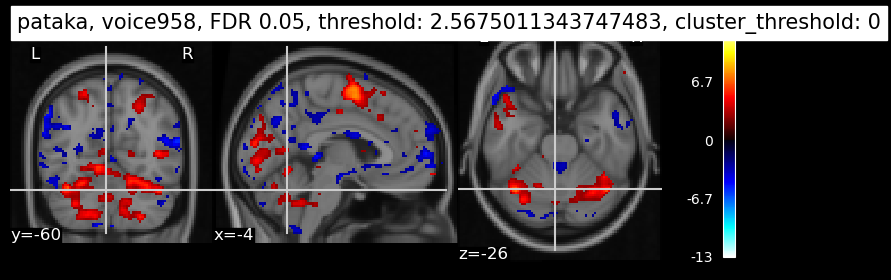

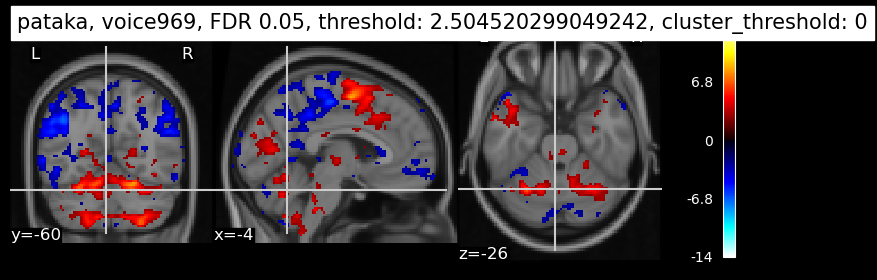

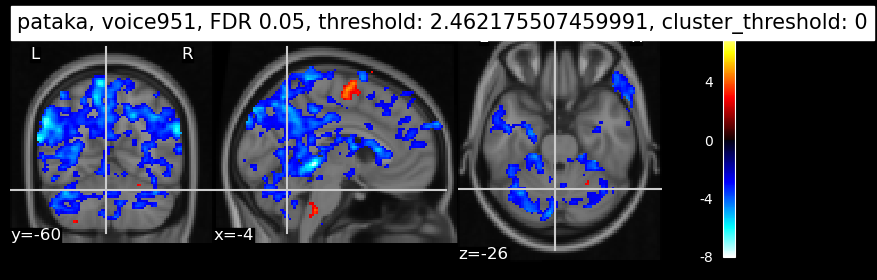

/om2/user/rfbrito/miniconda/envs/imaging/lib/python3.11/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.181503630102876. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


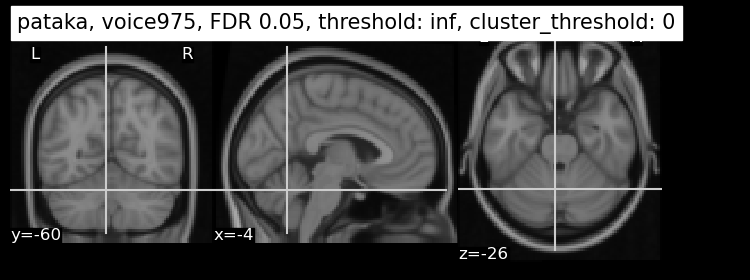

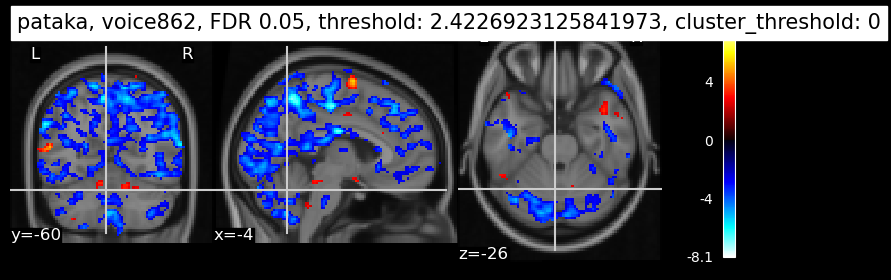

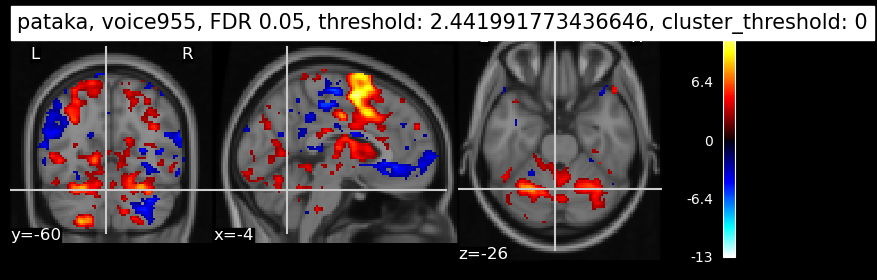

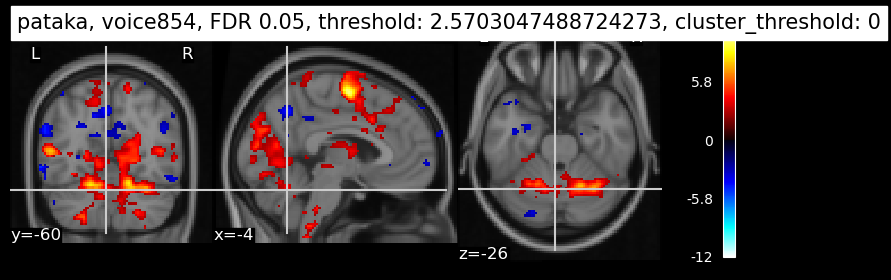

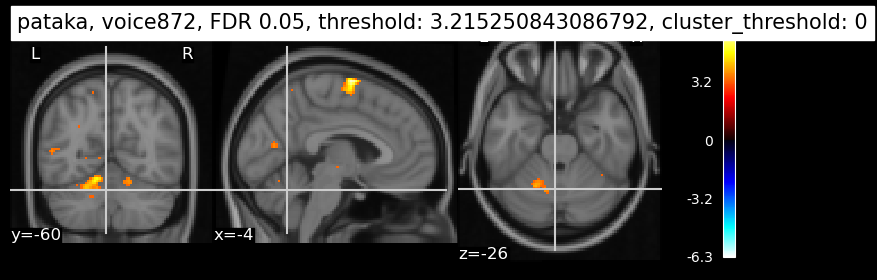

In [15]:
#threshold = 2.5

for rows in design_df.itertuples(index=False):

    #LH motor coordinates
    #coord = [-54,0,3]
    
    #cerebellum
    coord = [-4,-60,-26]

    t = rows.task
    sub = rows.subject
    
    contrast = create_contrast(rows.fitted_glm.design_matrices_[0],t)
    zmap = create_zmap(rows.fitted_glm,contrast)
    
    alpha = 0.05
    cluster_threshold = 0
    fdr_map = threshold_stats_img(zmap, height_control='fdr', alpha=alpha, cluster_threshold=cluster_threshold)

    thresh = fdr_map[1]
    #cut_coords=coord,

    plot_stat_map(fdr_map[0], bg_img=template,cut_coords=coord,
                      display_mode='ortho', 
                      black_bg=True,
                      title=f'{t}, {sub}, FDR {alpha}, threshold: {thresh}, cluster_threshold: {cluster_threshold}')
    plt.show()

#     plot_stat_map(zmap, bg_img=template, threshold=threshold,
#                   display_mode='ortho', cut_coords=coord,
#                   black_bg=True,
#                   title=f'{t}, {sub} (Z>{threshold}), sparse scan')
#     plt.show()

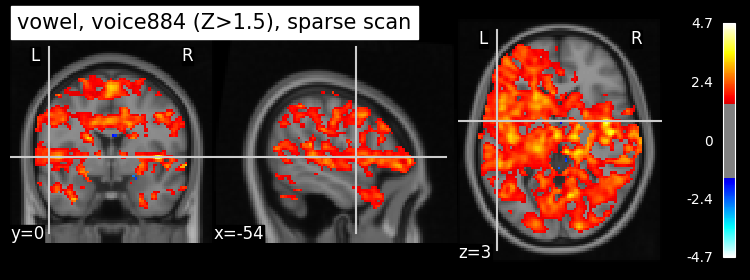

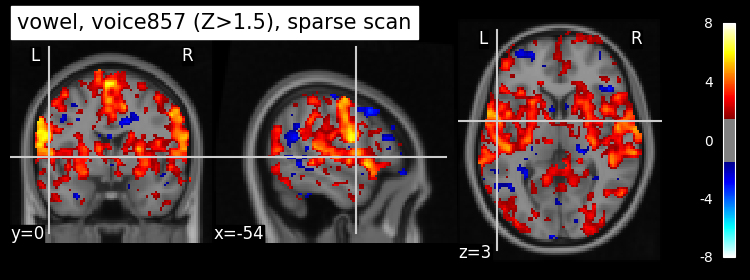

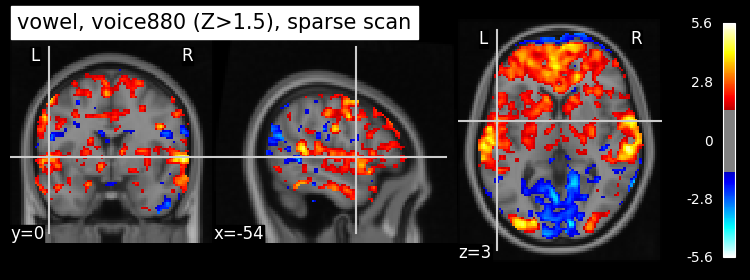

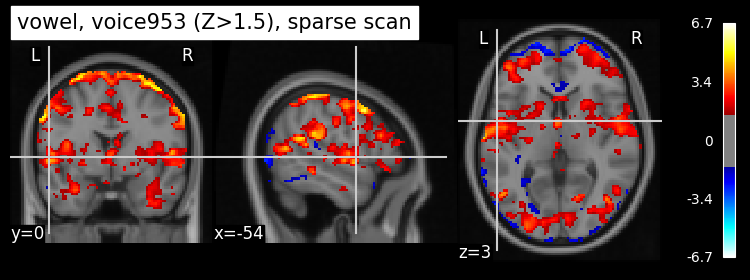

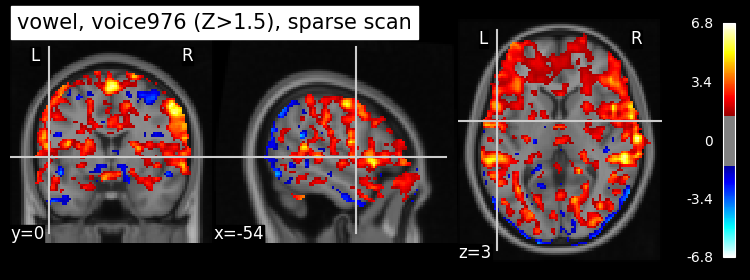

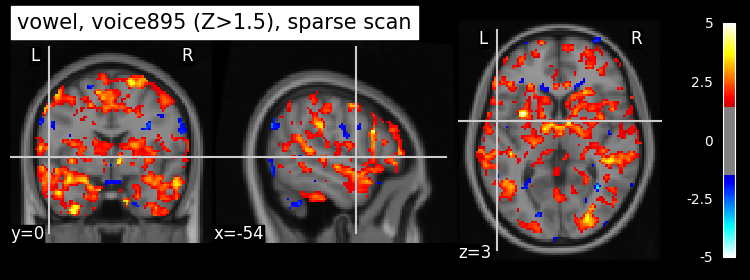

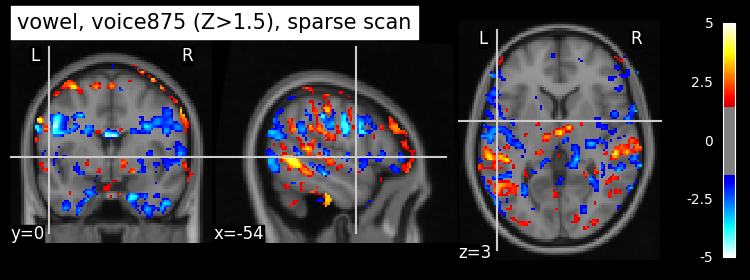

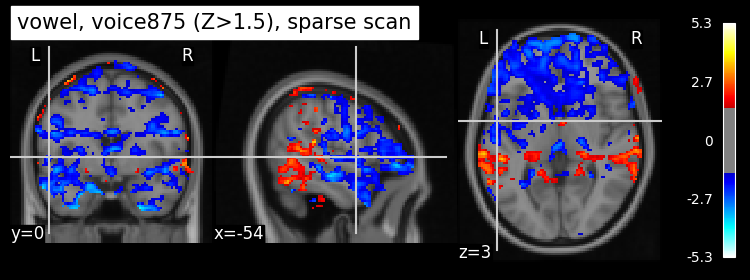

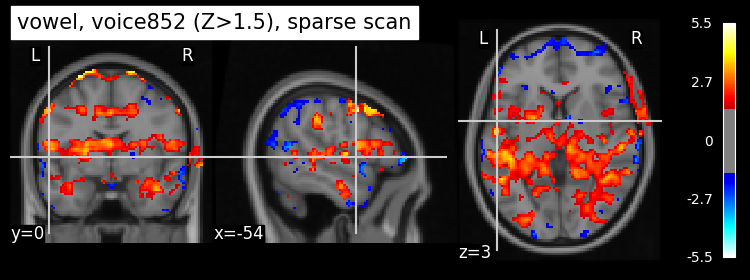

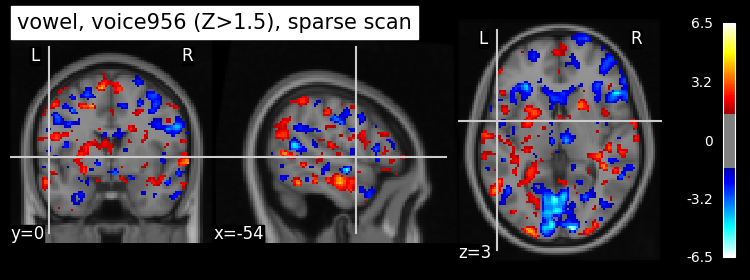

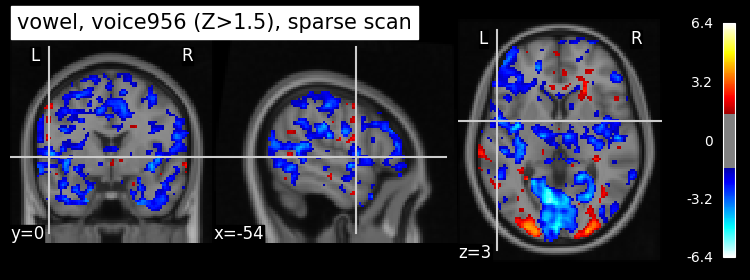

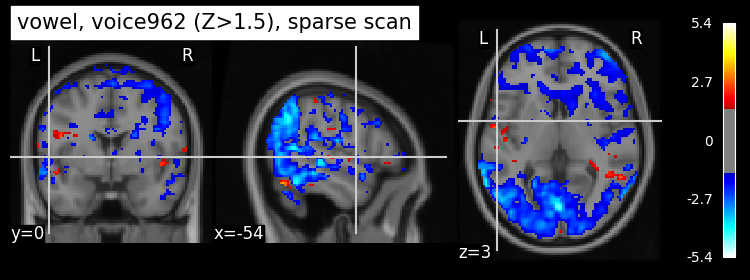

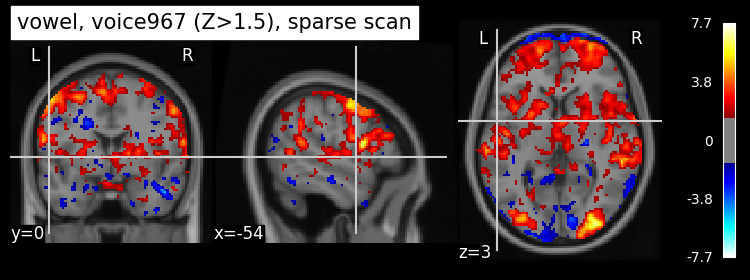

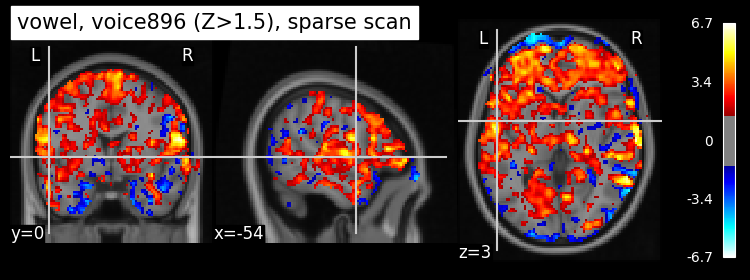

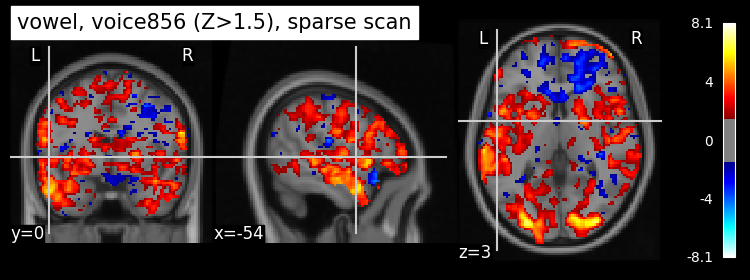

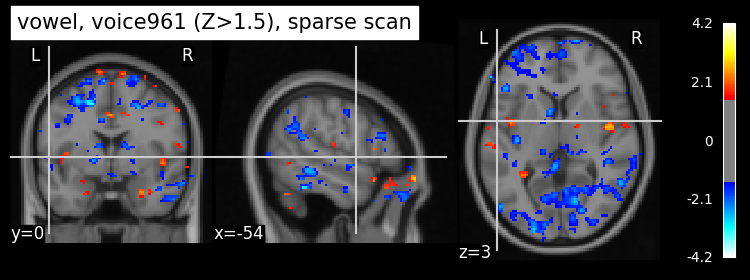

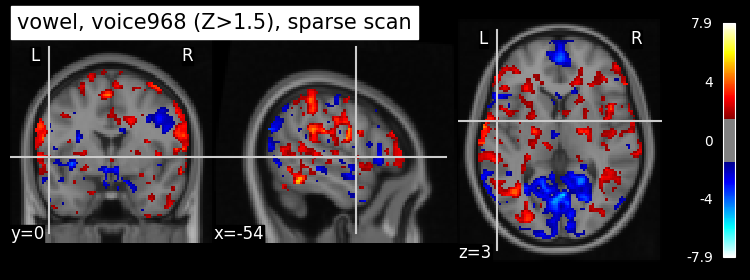

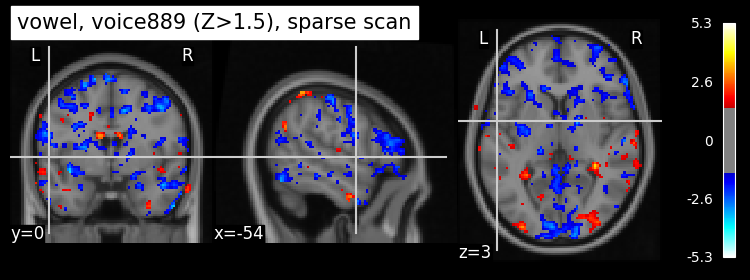

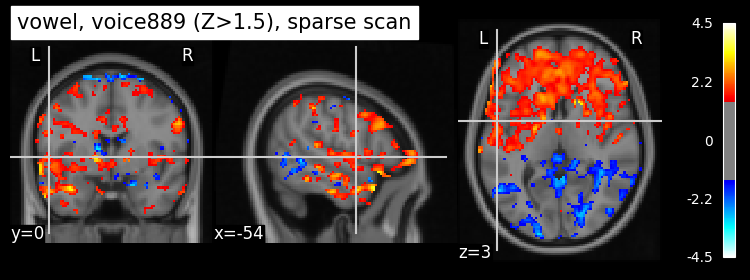

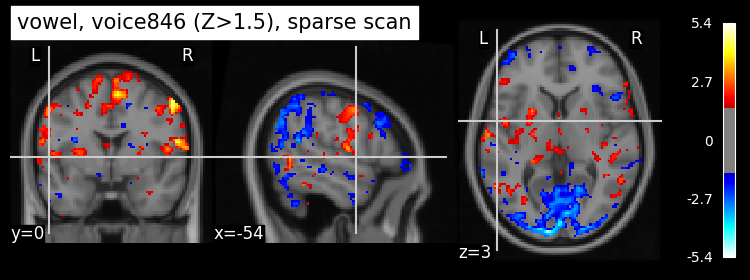

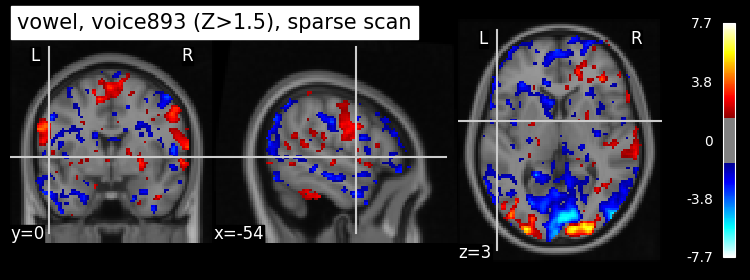

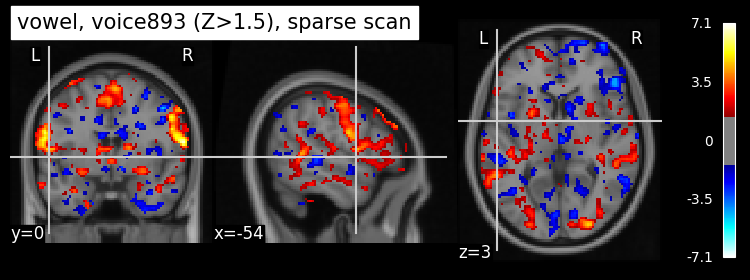

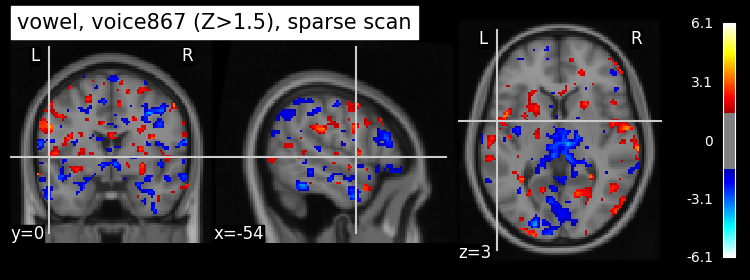

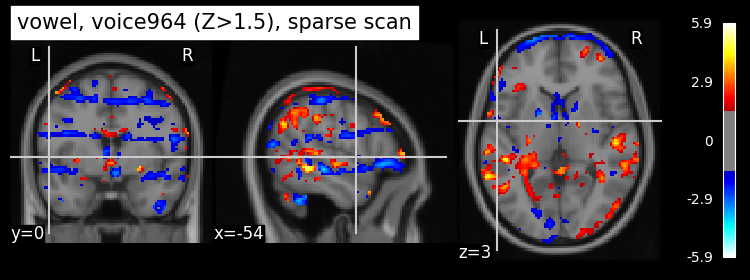

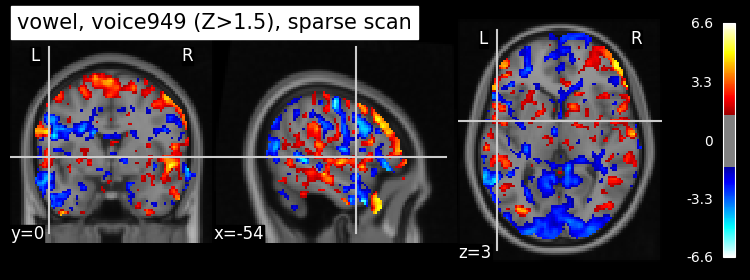

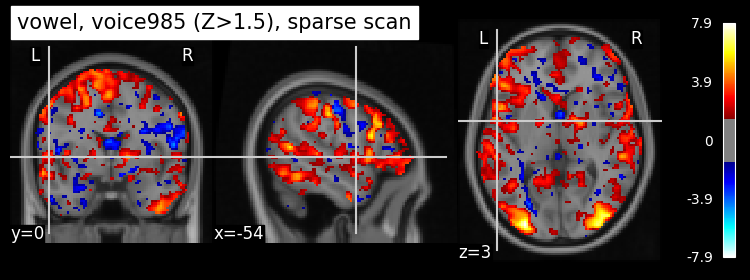

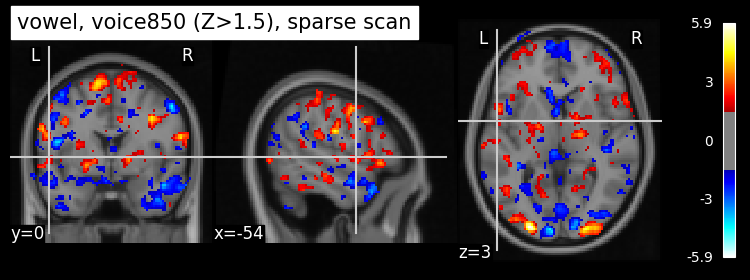

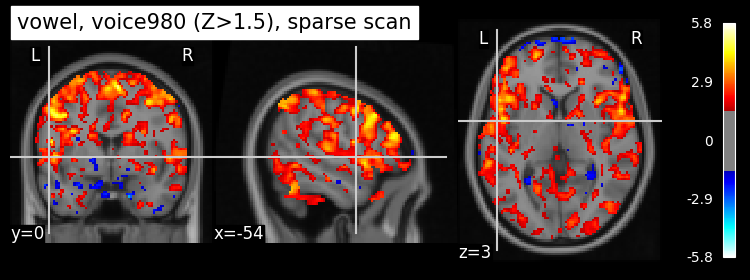

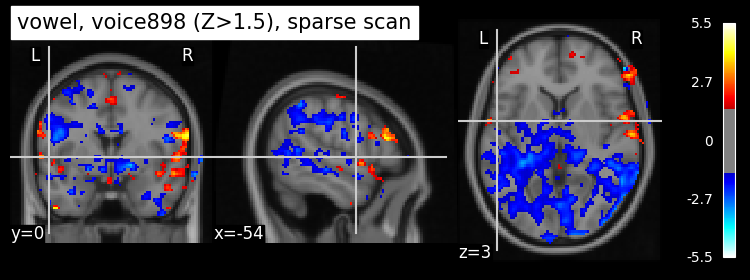

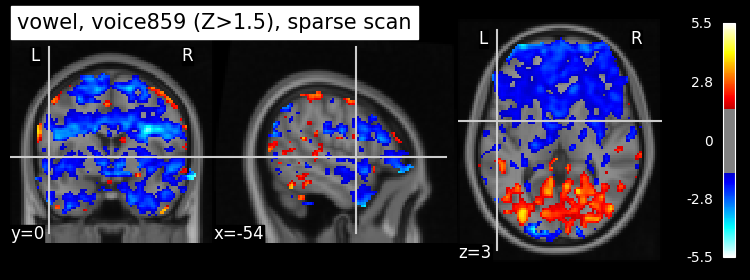

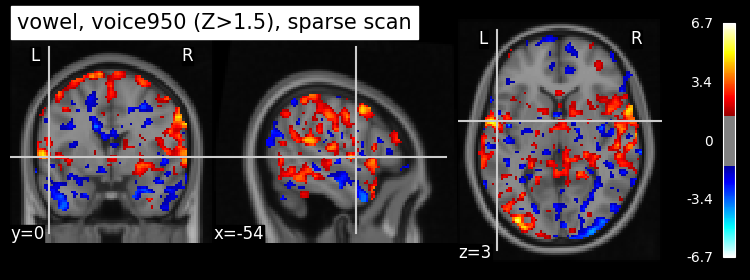

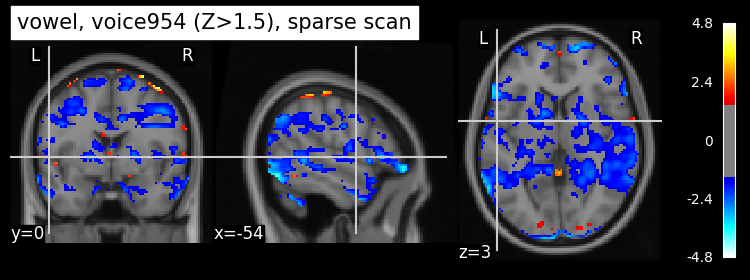

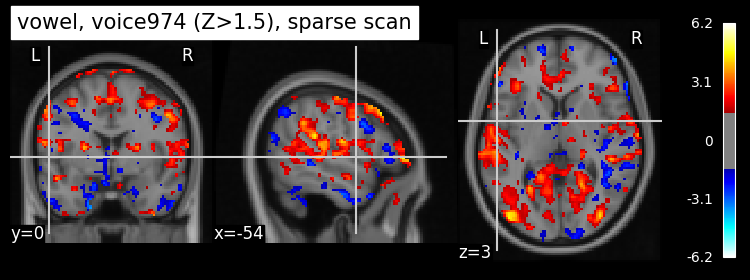

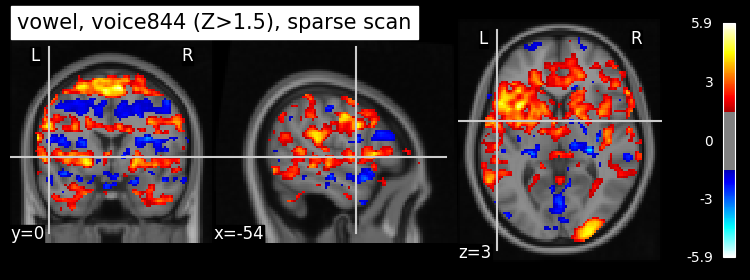

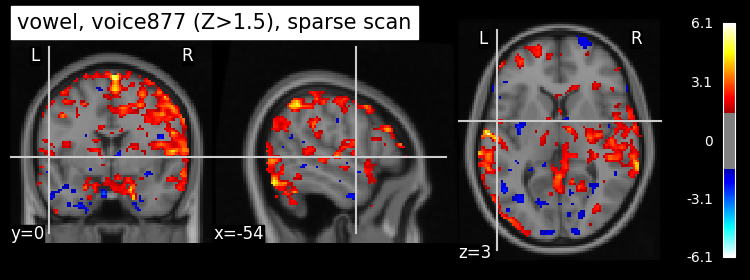

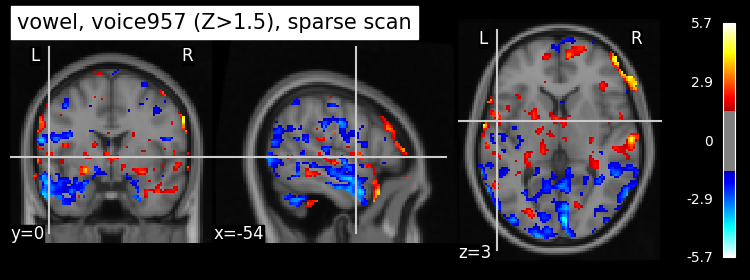

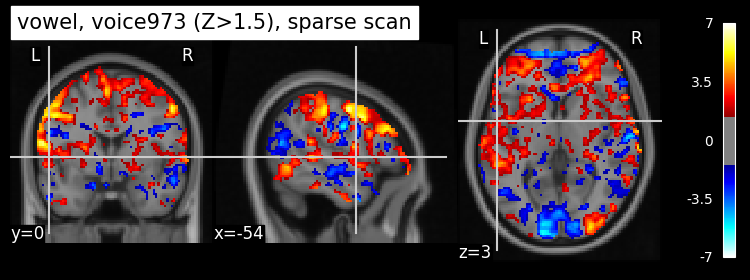

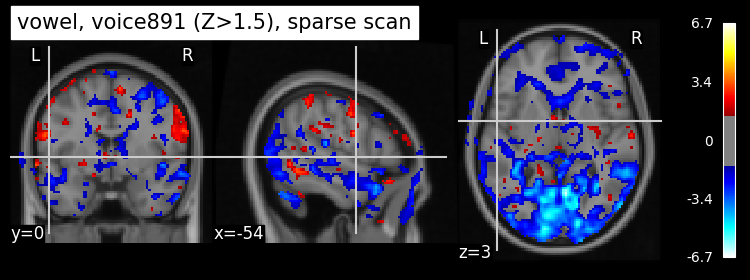

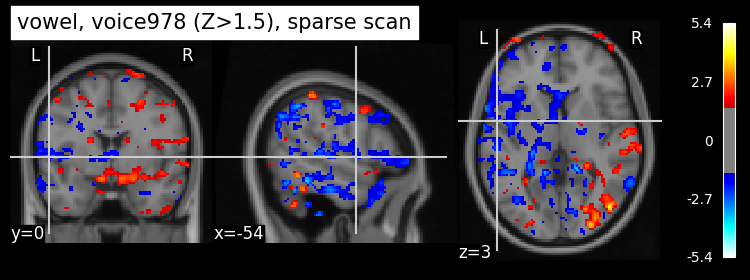

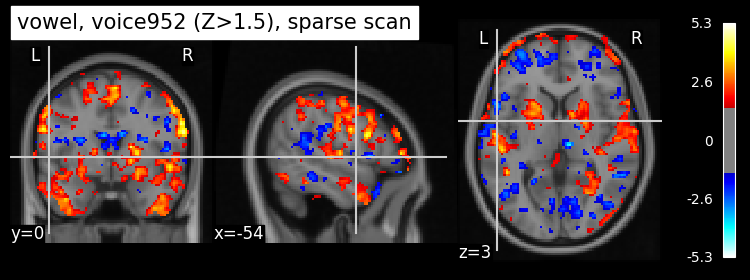

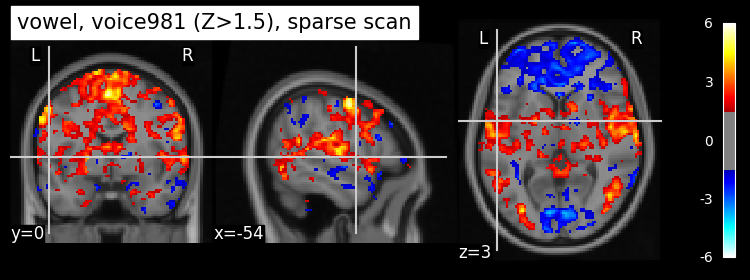

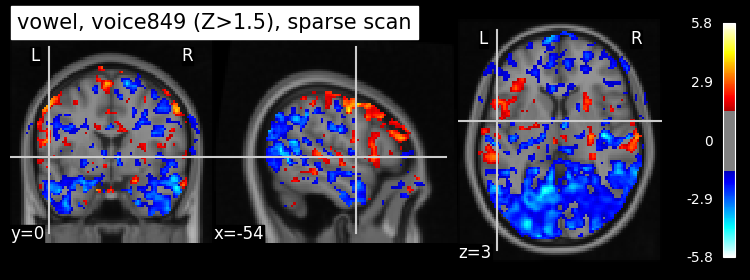

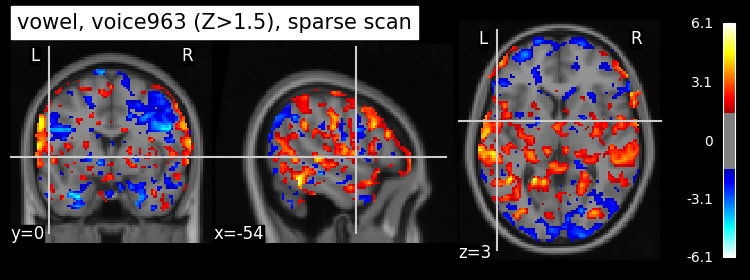

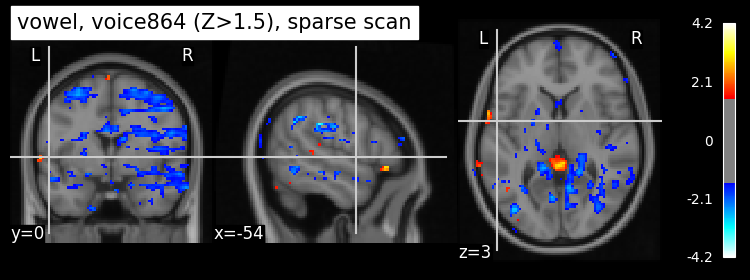

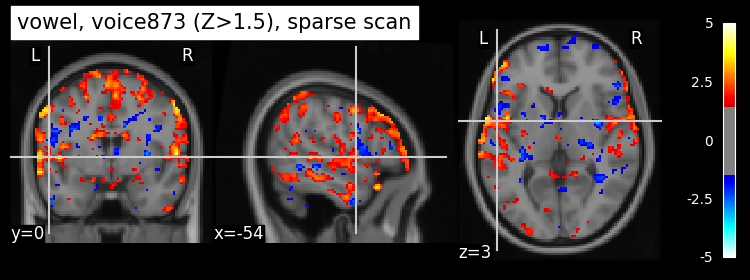

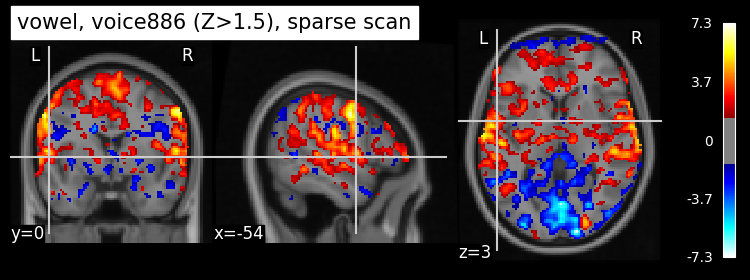

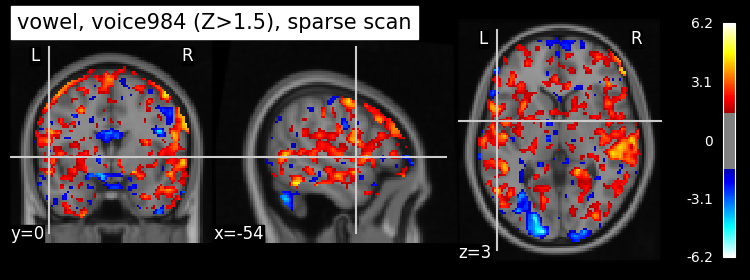

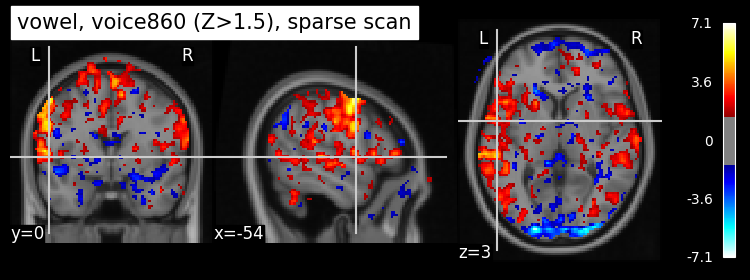

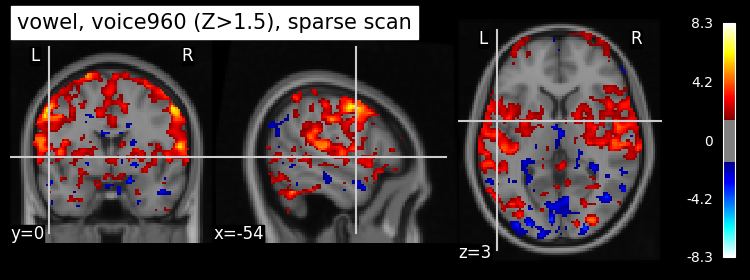

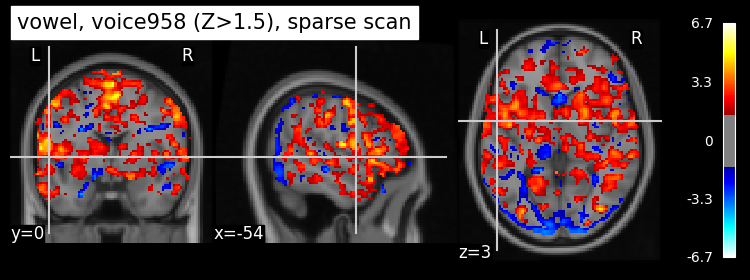

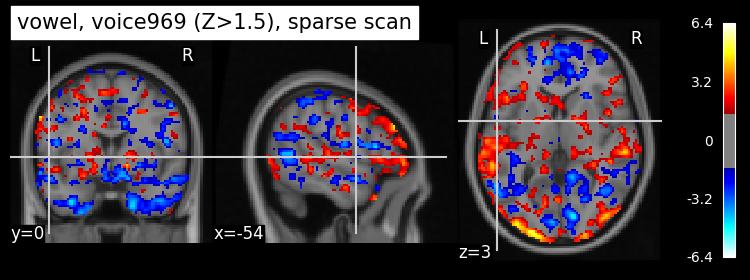

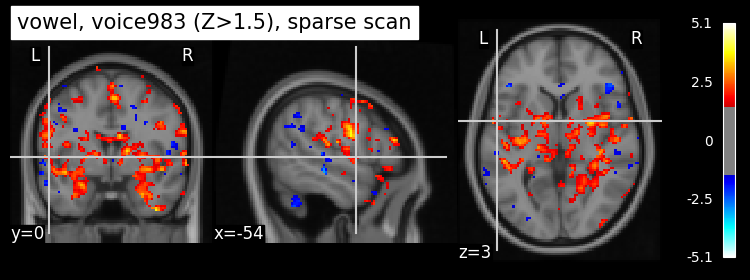

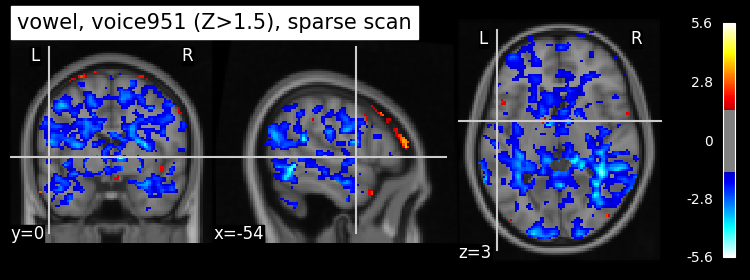

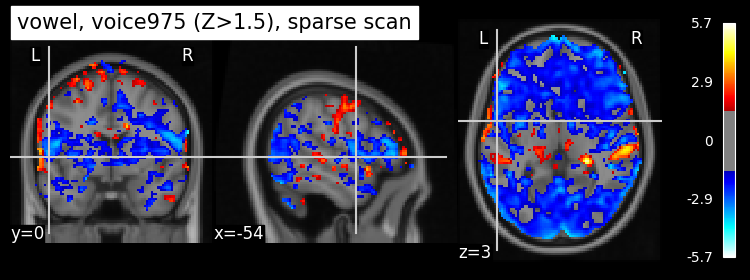

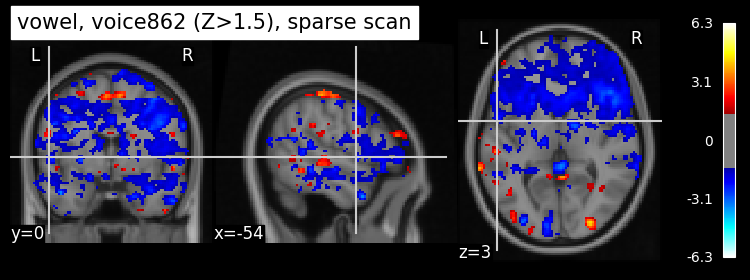

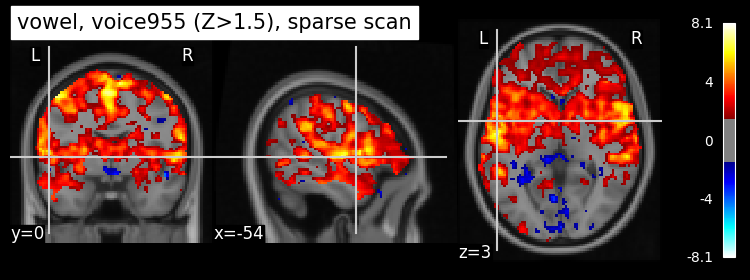

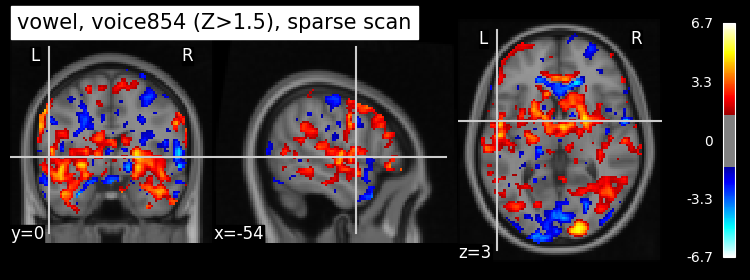

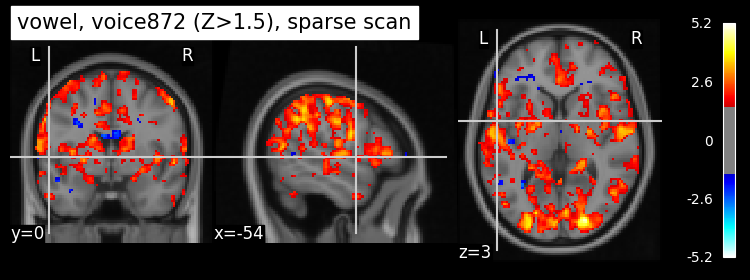

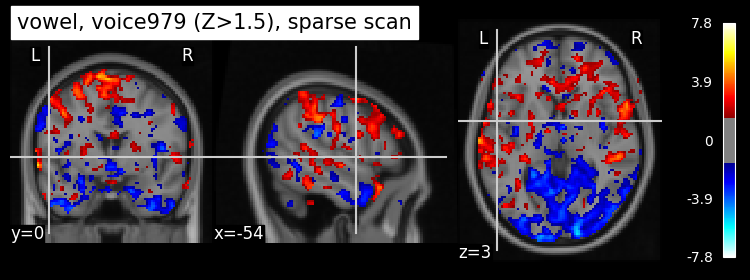

In [58]:
threshold = 1.5

for rows in design_vowel_df.itertuples(index=False):

    coord = [-54,0,3]

    t = rows.task
    sub = rows.subject
    
    contrast = create_contrast(rows.fitted_glm.design_matrices_[0],t)
    zmap = create_zmap(rows.fitted_glm,contrast)
    
#     alpha = 0.1
#     cluster_threshold = 0
#     fdr_map = threshold_stats_img(zmap, height_control='fdr', alpha=alpha, cluster_threshold=cluster_threshold)
    
#     thresh = fdr_map[1]
    
#     plot_stat_map(fdr_map[0], bg_img=template,cut_coords=coord,
#                       display_mode='ortho', 
#                       black_bg=True,
#                       title=f'{t}, {sub}, FDR {alpha}, threshold: {thresh}, cluster_threshold: {cluster_threshold}')
#     plt.show()

    plot_stat_map(zmap, bg_img=template, threshold=threshold,
                  display_mode='ortho', cut_coords=coord,
                  black_bg=True,
                  title=f'{t}, {sub} (Z>{threshold}), sparse scan')
    plt.show()

In [25]:
debug = design_df[(design_df.subject=='voice957') & (design_df.task=='vowel')]

In [31]:
glm_d = debug.fitted_glm.iloc[0]

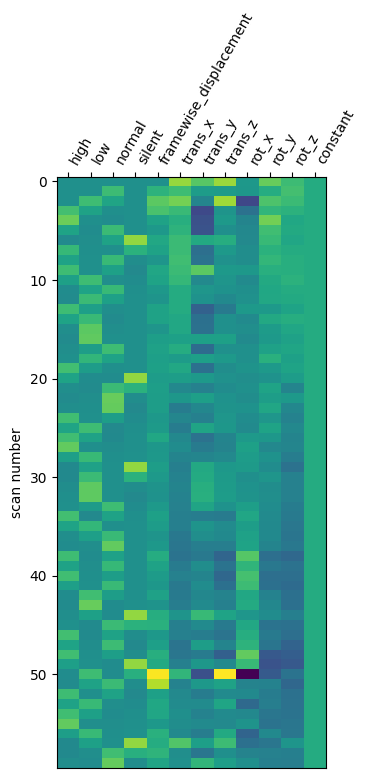

In [33]:
show_design_matrix(glm_d)

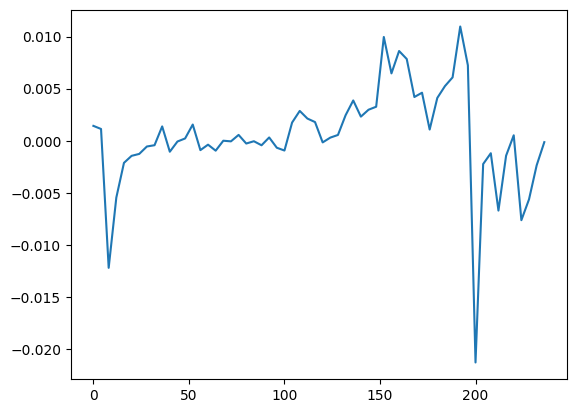

In [38]:
plt.plot(glm_d.design_matrices_[0].index, glm_d.design_matrices_[0].rot_x)

In [3]:
#first level glm model


def run_first_level_model(sub,task,ses,run,sparse,mask, smoothing_fwhm=5):
    #memory = './nilearn_cache' #change if desired
    space='MNI152NLin6Asym' #change if desired
    
    task_json = open(f"../../task-{task}_bold.json")
    task_json=json.load(task_json)
    TR=task_json['RepetitionTime']
    
    nifti = glob.glob(f'../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-{run}*{space}*preproc*nii.gz')[0]
    events = glob.glob(f'/om/project/voice/bids/data/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-0{run}*events.tsv')
    
    #'voice*/ses-*/func/*{task}*events.tsv'
    #mask = glob.glob(f'../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-{run}*{space}*brain_mask.nii.gz')[0]

    selected_confounds=get_confounds(sub,task,ses,run)

    #choose middle slice as reference since fmriprep default for slice timing correction
    #already accounting for drift and high pass filter with cosine regressors (I believe)
    #might want to change to this at some point: minimize_memory=False
    #spm + derivative + disperson should account for undershoot and slight variances in HRF across ppl/regions
    #satra: twice the voxel resolution, so probs 4
    #satra: signal_scaling look more into it, doesn't affect stats but does affect effect size 
    glm = FirstLevelModel(t_r=TR,
                          smoothing_fwhm=smoothing_fwhm, 
                          noise_model='ar1',
                          mask_img=mask,
                          drift_model=None,
                          standardize=False,
                          hrf_model='spm',
                          high_pass=.01)
        #t_r = TR,
        #slice_time_ref=0.5, smoothing_fwhm=6.0, hrf_model='spm + derivative + dispersion', drift_model=None,
        #high_pass=None, drift_order=4, standardize=False, signal_scaling=False, noise_model='ar1',
        # minimize_memory=True, verbose=0, n_jobs=-2)
    #memory=memory,

    fitted_glm = glm.fit(nifti, events=events[0], confounds=selected_confounds)
    
    #designed to catch and log the runs that fail
    if sparse:
        try:
            sparse_scan_regressors = generate_sparse_scan_regressors(nifti, fitted_glm, task_json, events)
            fails = None
            for event_type in sparse_scan_regressors.columns:
                fitted_glm.design_matrices_[0][event_type] = sparse_scan_regressors[event_type]
        except Exception as Arguement:
            fails = Arguement         
        

    return [fitted_glm, nifti, events, fails]


In [4]:
def find_populated_events(events_path_pattern):

    #get list of all events file in bids directory (using old location) per task as df
    #pop_events = pd.DataFrame(glob.glob(f'/om/project/voice/bids/data/sub-voice*/ses-*/func/*{task}*events.tsv'), columns= ['events_file'])

    pop_events = pd.DataFrame(glob.glob(events_path_pattern), columns= ['events_file'])

    #use pd empty attribute to determine if file is empty or not. 
    #invert the boolean value as I want to know if it is popualated or not
    pop_events['populated'] = [not pd.read_table(f).empty for f in pop_events.events_file]

    pop_events['task'] = [parse_file_entities(file)['task'] for file in pop_events.events_file]

    return pop_events

In [5]:
#get confounds for any subject and task

def get_confounds(sub,task,ses,run):

    all_confounds = pd.read_csv(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')
    
    all_confounds_json = open(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.json")
    all_confounds_json=json.load(all_confounds_json)
    
    
    #typically included rigid body motion (or those plus squares and derivatives if desired, then must comment out top line and uncomment bottom 3)
    motion_params = ['trans_x', 'trans_y', 'trans_z','rot_x','rot_y','rot_z']
    # motion_trans_params = [col for col in all_confounds.columns if 'trans' in col] #change to these squares and derivatives if desired
    # motion_rot_params = [col for col in all_confounds.columns if 'rot' in col] #change to these if desired
    # motion_params=motion_trans_params+motion_rot_params #change to these if desired

    
    #individual col with single 1 for timepoint of motion
    motion_outliers = [col for col in all_confounds.columns if 'motion_outlier' in col]  
    
    
    #for low freq signal drift
    #cannot include this and high-pass temp filter bc already removes low freq fluc
    #required if using aCompCor (or tCompCor)
    #cosine_regressors = [col for col in all_confounds.columns if 'cosine' in col] 
    
    
    #these can be adjusted to be from the combined wm csf, for example
    #doesn't make sense to use csf and wm signal regression if using these according to fmriprep documentation
    #6 is rule of thumb; can pick diff number or specific amount of variance explained
    #TO DO clarify if edge/crown regressors are already part of compcor -- unclear in docs and can't find separate regressor in tsv
    #num_a_comp_cors=6
    #a_comp_cors = []
    #for i in range(num_a_comp_cors):
    #    a_comp_cors.append('a_comp_cor_{:02d}'.format(i))
    
        
    #if taking ICA AROMA denoised niftis (~desc-smoothAROMAnonaggr_bold.nii.gz), can't also include ICA noise regressors & MUST drop non-steady state vols
    #here we are taking instead the ICA AROMA regressors: aroma_motion_XX
    #aroma_regressors_all = [col for col in all_confounds.columns if 'aroma' in col]
    #aroma_regressors_noise=[]
    #TO DO: excluding for now, but double check on this!
#     for regr in aroma_regressors_all:
#         json_name ='aroma_motion_'+str(int(regr.split('aroma_motion_')[1]))
#         if all_confounds_json[json_name]['MotionNoise']==True:
#             aroma_regressors_noise.append(regr)
        

    #we need to filter out non-steady state volumes if using cosine regressors, ICA AROMA and CompCor regressors...    
    #non_steady_state_regressors = [col for col in all_confounds.columns if 'non_steady_state' in col]
           
    #TO DO: not sure if CSF should be kept since already have aCompCors (excluding for now)
    #selected_confounds = all_confounds[['framewise_displacement']+motion_params+motion_outliers+cosine_regressors+a_comp_cors+aroma_regressors_noise+non_steady_state_regressors].copy()

    #selected_confounds = all_confounds[['framewise_displacement']+motion_params].copy()
    
    selected_confounds = all_confounds[['framewise_displacement']+motion_params+motion_outliers].copy()

    #get rid of nas in first row of derivative and framewise displacement cols
    for col in selected_confounds.columns:
        if ('derivative' in col) or ('framewise_displacement' in col):
            if pd.isna(selected_confounds[col][0]):
                selected_confounds[col][0]=0

    return selected_confounds



In [6]:
def generate_sparse_scan_regressors(nifti, fitted_glm, task_json, events):
    
    TR=task_json['RepetitionTime']
    DT=task_json['DelayTime']

    sparse_model = modelgen.SpecifySparseModel()
    sparse_model.inputs.input_units = 'secs'
    sparse_model.inputs.functional_runs = nifti
    sparse_model.inputs.time_repetition = TR
    sparse_model.inputs.time_acquisition = TR - DT
    sparse_model.inputs.high_pass_filter_cutoff = 128.
    sparse_model.inputs.model_hrf = True
    sparse_model.inputs.subject_info = modelgen.bids_gen_info(events,condition_column='trial_type')  # doctest: +SKIP

    regressors = sparse_model._list_outputs()['session_info'][0]['regress']
    data = [v['val'] for v in regressors]
    col = [t['name'] for t in regressors]
    df_regressors = pd.DataFrame(data).T
    df_regressors.columns = col
    df_regressors.index = fitted_glm.design_matrices_[0].index
    
    return df_regressors

In [7]:
#plot design matrix for one subject
#not needed to be run unless one wants to see it

def show_design_matrix(fitted_glm):
    for design_matrix in fitted_glm.design_matrices_:
        plot_design_matrix(design_matrix)
        plt.show()

In [8]:

def create_contrast(design_matrix, task):
    #fmri_img = concat_imgs(nifti)
    #mean_img = mean_img(fmri_img)
    
    speech_contrast = np.zeros(design_matrix.shape[1])
    
    if task == 'pataka':
        clear = np.zeros(design_matrix.shape[1])
        clear[0] = 1
        normal = np.zeros(design_matrix.shape[1])
        normal[1] = 1
        rapid = np.zeros(design_matrix.shape[1])
        rapid[2] = 1
        silent = np.zeros(design_matrix.shape[1])
        silent[3] = 1


        conditions = {
            'clear': clear,
            'normal': normal,
            'rapid': rapid,
            'silent': silent
        }

        speech_contrast = 0.33*conditions['clear'] + 0.33*conditions['normal'] + 0.33*conditions['rapid'] - conditions['silent']
    
    if task == 'emosent':
        happy= np.zeros(design_matrix.shape[1])
        happy[0] = 1
        neutral= np.zeros(design_matrix.shape[1])
        neutral[1] = 1
        sad = np.zeros(design_matrix.shape[1])
        sad[2] = 1
        silent = np.zeros(design_matrix.shape[1])
        silent[3] = 1
        
        conditions = {
            'happy': happy,
            'neutral': neutral,
            'sad': sad,
            'silent': silent
        }
        
        speech_contrast = 0.33*conditions['happy'] + 0.33*conditions['neutral'] + 0.33*conditions['sad'] - conditions['silent']
    
    if task == 'nwr':
        two = np.zeros(design_matrix.shape[1])
        two[0] = 1
        three= np.zeros(design_matrix.shape[1])
        three[1] = 1
        four = np.zeros(design_matrix.shape[1])
        four[2] = 1
        five = np.zeros(design_matrix.shape[1])
        five[3] = 1
        rest = np.zeros(design_matrix.shape[1])
        rest[4] = 1
        
        conditions = {
            '2': two,
            '3': three,
            '4': four,
            '5': five,
            'Rest' : rest
        }
        
        speech_contrast = 0.25*conditions['2'] + 0.25*conditions['3'] + 0.25*conditions['4'] + 0.25*conditions['5'] - 0.25*conditions['Rest']
    
    if task == 'vowel':
        
        high = np.zeros(design_matrix.shape[1])
        high[0] = 1
        low= np.zeros(design_matrix.shape[1])
        low[1] = 1
        normal = np.zeros(design_matrix.shape[1])
        normal[2] = 1
        silent = np.zeros(design_matrix.shape[1])
        silent[3] = 1
        
        conditions = {
            'high': high,
            'low': low,
            'normal': normal,
            'silent': silent
        }
        
        speech_contrast = 0.33*conditions['high'] + 0.33*conditions['low'] + 0.33*conditions['normal'] - conditions['silent']
    
    return speech_contrast

#plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)
    

In [9]:
def create_zmap(fitted_glm, speech_contrast):
    
    zmap = fitted_glm.compute_contrast(speech_contrast,
                                  output_type='z_score')
    
    return zmap

In [12]:
# d = pop_events.groupby('task')
# first = {}

# for g, v in d:
#     first[g]=v.iloc[0] 
    
#first.keys()
#pd.read_table(first['vowel'].events_file).trial_type.unique()
#first['vowel'].events_file

In [5]:
#create all desired contrasts

#satra: combine image and arrow regressors because highly collinear!!! can do a correlation matrix of all regressors of design matrix to see if we need to throw out a contrast/subject (anything >0.3 or 0.4 is a high correlation)
#on second thought might be ok to keep them apart

def make_localizer_contrasts(design_matrix,task,selected_confounds):
    """ returns a dictionary of contrasts, given the design matrix"""

    # first generate canonical contrasts based on the design matrix columns 
    contrast_matrix = np.eye(design_matrix.shape[1])
    canonical_contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    
    
    #initialize dictionary of contrasts desired for analysis of respective task
    final_contrasts={}
    
    #initialize list of complex contrasts, which are combinations of the canonical contrasts
    task_contrasts = []
    
    #complex contrasts for nback task (must include a '-' or '+' and be made up of canonical contrasts)
    if task == 'nback':
        task_contrasts = ['twoback-zeroback']
    
    #complex contrasts for mid task (must include a '-' or '+' and be made up of canonical contrasts)
    if task == 'mid':
        task_contrasts = ['HiRewCue-NeuCue', #high reward anticipation
                          'LoRewCue-NeuCue', #low reward anticipation
                          'HiLossCue-NeuCue', #high loss anticipation
                          'LoLossCue-NeuCue', #low loss anticipation
                          
                          'HiWin-NeuHit', #high reward outcome cp. to neutral hit
                          'LoWin-NeuHit', #low reward outcome cp. to neutral hit
                          'HiWin-HiNoWin', #high reward outcome cp. to high reward miss
                          'LoWin-LoNoWin', #low reward outcome cp. to low reward miss
                          
                          'HiLoss-NeuMiss', #high loss cp. to neutral miss
                          'LoLoss-NeuMiss', #low loss cp. to neutral miss
                          'HiLoss-AvoidHiLoss', #high loss cp. to avoid high loss
                          'LoLoss-AvoidLoLoss', #low loss cp. to avoid low loss
                          
                          'HiRewCue+LoRewCue-NeuCue', #combined reward anticipation
                          'HiLossCue+LoLossCue-NeuCue', #combined loss anticipation
                          
                          'HiWin+LoWin-NeuHit', #combined reward outcome cp. to neutral hit
                          'HiWin+LoWin-HiNoWin-LoNoWin', #combined reward outcome cp. to combined reward miss
                          
                          'HiLoss+LoLoss-NeuMiss', #combined loss cp. to neutral miss
                          'HiLoss+LoLoss-AvoidHiLoss-AvoidLoLoss' #combined loss cp. to combined avoid loss  
                         ]
    
    #complex contrasts for sst task (must include a '-' or '+' and be made up of canonical contrasts)
    #TO DO: need to add contrasts to capture comparison between MJ trial and Neutral trial for arrow/stop 
    #TO DO: need to add contrasts to capture comparison between MJ trial and Neutral trial for images
#     if task == 'sst':
#         print('here')
#         task_contrasts = ['N_SuccStop_arrow-N_Go_arrow', #correct inhibition normal
#                           'MJ_SuccStop_arrow-MJ_Go_arrow', #correct inhibition MJ
#                           'N_UnsuccStop_arrow-N_Go_arrow', #incorrect inhibition normal
#                           'MJ_UnsuccStop_arrow-MJ_Go_arrow', #incorrect inhibition MJ
#                           'N_UnsuccStop_arrow-N_SuccStop_arrow', #successful inhibitory control normal
#                           'MJ_UnsuccStop_arrow-MJ_SuccStop_arrow' #successful inhibitory control MJ
#                          ]
    
    #for loop that creates complex contrasts based on the string names from the task_contrasts list created above
    for task_contrast in task_contrasts:
        #split complex contrast string into a list of canonical contrasts separated by '-' or '+' 
        #'-' and '+' are maintained in the list due to the () around the deliminator specified in re.split
        events = re.split('([\-\+])', task_contrast)
        
        #check if all canonical contrasts needed for a given complex contrast were present in a subject's data
        #note that sometimes a participant eg. never had a miss on a type of trial, so the miss regressor doesn't exist 
        #can comment out print statements to see which contrasts are being generated vs. for which events are missing
        if len(set(events).intersection(set(canonical_contrasts.keys()))) < np.ceil(len(events)/2):
            #print(f'issue with: {task_contrast}')
            continue
        #print(f'checking passed for {task_contrast}')
        
        #set up placeholder for array containing matrix for the complex contrast
        complex_contrast = 0
        #set up how the canonical contrasts will be added/subtracted to create the complex contrast
        math_sign = '+'
        plus_multiplier = 1
        minus_multiplier = 1
        #this only applies to the mid task, since the nback and sst tasks' complex contrasts are only made up of two canonical contrasts
        #if mid list consists of 5 elements (i.e. 3 canonical contrasts and 2 math symbols), there is always 1 '+' and 1 '-' (in addition to the implied '+ at the beginning)
        #in that case, we need to multiply the 2 canonical constrasts after the '+' and implied '+' by 0.5
        if len(events) == 5:
            plus_multiplier = 0.5
        #if mid list consists of 7 elements (i.e. 4 canonical contrasts and 3 math symbols), there is always 1 '+' and 2 '-' (in addition to the implied '+ at the beginning)
        #in that case, we need to multiply the 4 canonical constrasts by 0.5
        if len(events) == 7:
            minus_multiplier = 0.5
            plus_multiplier = 0.5
            
        #do the complex contrast calculation
        for el in events:
            #math_sign starts of with '+' as set up above since the first canonical contrast has an implied '+' at the beginning (added to the 0 that we used to initialize the complex contrast)
            if el in ['+','-']:
                math_sign = el
            #if current list element isn't a math sign, then it's a canonical contrast and we add/subtract based on the math sign we set
            #we also multiply the canonical contrast by 1 (default) or 0.5 (certain mid complex contrasts)
            else:
                if math_sign == '+':
                    complex_contrast = complex_contrast + plus_multiplier*canonical_contrasts[el]
                if math_sign == '-':
                    complex_contrast = complex_contrast - minus_multiplier*canonical_contrasts[el]
        #at the end we store the created complex contrast        
        final_contrasts[task_contrast] = complex_contrast       
                
        
    #add a nuisance regressor contrast to the final set of contrasts that includes all nuisance regressors
    #firs set up zeros matrix of correct shape
    final_contrasts['nuisance_regressors']=np.zeros(design_matrix.shape[1])
    #this iteratively adds a 1 in place of all the confounds in the zeros matrix
    for confound in selected_confounds.columns:
        final_contrasts['nuisance_regressors']=final_contrasts['nuisance_regressors']+canonical_contrasts[confound]
    
    #return dictionary of all complex contrasts
    return final_contrasts


In [6]:
#loop over all subjects to store first level GLM results

def save_first_level_outputs(input_list):
    sub,task,ses,run = input_list
    print(f'Now processing subject {sub} for task {task} in session {ses} run {run}')
    
    #check that input exists
    nifti = glob.glob(f'../../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-unco*run-{run}*{space}*preproc*nii.gz')
    if not nifti: #checks if list is empty
        print(f'1st level input does not exist for subject {sub}, session {ses}, run {run} and task {task}. Cannot generate output.')
        return
    
    #check that output does not exist
    output = glob.glob(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-*_effect_size.nii.gz')
    if output: #checks if list is not empty
        print(f'At least partial 1st level output exists for subject {sub}, session {ses}, run {run} and task {task}. This must be deleted for before generating new output.')
        return    
    
    #run first level model 
    #note confounds are subject specific! 
    fitted_glm, selected_confounds = run_first_level_model(sub,task,ses,run)         
    
    #define contrasts for task
    #note constrasts are subject specific due to varying numbers of confounders        
    contrasts = make_localizer_contrasts(fitted_glm.design_matrices_[0],task,selected_confounds)

    for contrast in contrasts.keys():
        #calculate contrast maps for all contrasts
        #satra: f test for all nuisance regressors and look at map to see what areas are affected 
        #TO DO: F is a 2D contrast, so unclear if that makes sense/works if nuisance contrast is 1D array
        #F usually means is any of these 1D contrasts significant?
        #can also just not set stat_type and will default to t or F, depending on dim of contrast
        if contrast == 'nuisance_regressors':
            contrast_output = fitted_glm.compute_contrast(contrasts[contrast], output_type='all',stat_type='F')
        else:   
            contrast_output = fitted_glm.compute_contrast(contrasts[contrast], output_type='all',stat_type='t')
        
        #create paths to output dir if not exist
        derivatives_path = '../../../derivatives'
        nilearn_output_path = os.path.join(derivatives_path, 'nilearn','first_level',f'sub-{sub}',f'ses-{ses}',f'task-{task}')
        if not os.path.isdir(nilearn_output_path):
            os.makedirs (nilearn_output_path)
            
        #save contrast maps to files
        contrast_output['effect_size'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_effect_size.nii.gz')
        contrast_output['effect_variance'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_effect_variance.nii.gz')
        contrast_output['z_score'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_z_score.nii.gz')
        contrast_output['stat'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_stat.nii.gz')
        contrast_output['p_value'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_p_value.nii.gz')
    
    return
    

In [14]:
#select runs, tasks and sessions to process
#task_list=['sst','nback','mid']
#task_list=['nback','mid'] #since sst contrast isn't finalized
#ses_list=['baseline','1year']
#run_list=['1','2','3']

task_list=['nback']
ses_list=['baseline','1year']
run_list=['1','2','3']


# for task in task_list:
#     for ses in ses_list:
#         for run in run_list:
#             #find all subjects who have task niftis and events.tsv for this task, session & run
#             space='MNI152NLin6Asym' #change if desired
#             nifti = (glob.glob(f'../../../derivatives/ses-{ses}/sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-{run}*{space}*preproc*nii.gz'))
#             subjs_nifti = set([path.split(f'/ses-{ses}/')[1].split('-')[-1] for path in nifti])
#             events = (glob.glob(f'../../../sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-{run}*events.tsv'))
#             subjs_events = set([path.split(f'/ses-{ses}/')[0].split('-')[-1] for path in events if pd.read_csv(path).shape[0] != 0])
#             subjs = list(subjs_nifti.intersection(subjs_events))
#             for sub in subjs:
#                 if sub == 'MM273':
#                 #TO DO: this will become input to the script
#                 #if sub not in ['MM086','MM273']: #for 1year, run1: missing NeuMiss, NeuHit, respectively
#                 #if sub not in ['MM254','MM273']: #for 1year, run2: missing HiLoss, NeuHit, respectively
#                 #if sub not in ['HC023','HC035','MM254','MM283']:  #for baseline, run1: HC023 doesn't have NeuMiss; HC035 doesn't have NeuHit; MM254 doesn't have HiWin; MM283 doesn't have NeuMiss
#                 #if sub not in ['HC009','HC013','HC020','HC023','MM147','MM197','MM199','MM254','MM340']: #for baseline, run2: HC009 is missing NeuHit, HC013 is missing NeuHit; HC020 is missing HiNoWin;HC023 is missing HiLoss; MM147 is missing HiLoss; MM197 is missing NeuHit; MM199 is missing HiLoss; MM254 is missing HiWin; MM340 is missing NeuHit
#                 #if sub:
#                     input_list = sub,task,ses,run
#                     save_first_level_outputs(input_list)


inputs = []

for task in task_list:
    for ses in ses_list:
        for run in run_list:
            #find all subjects who have task niftis and events.tsv for this task, session & run
            space='MNI152NLin6Asym' #change if desired
            nifti = (glob.glob(f'../../../derivatives/ses-{ses}/sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-{run}*{space}*preproc*nii.gz'))
            subjs_nifti = set([path.split(f'/ses-{ses}/')[1].split('-')[-1] for path in nifti])
            events = (glob.glob(f'../../../sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-{run}*events.tsv'))
            subjs_events = set([path.split(f'/ses-{ses}/')[0].split('-')[-1] for path in events if pd.read_csv(path).shape[0] != 0])
            subjs = list(subjs_nifti.intersection(subjs_events))
            
            for sub in subjs:
                inputs.append([sub,task,ses,run])


# starting the monitoring
tracemalloc.start()

print(len(inputs))
n=20
input_chunks = [inputs[i::n] for i in range(n)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    for input_chunk in input_chunks:
        for single_input, prime in zip(input_chunk, executor.map(save_first_level_outputs, input_chunk)):
            print(' '.join(single_input) + ': processing done')
executor.shutdown()

# displaying the memory
print(tracemalloc.get_traced_memory())
 
# stopping the library
tracemalloc.stop()

        

59
Now processing subject MM096 for task nback in session 1year run 1
Now processing subject MM334 for task nback in session 1year run 1Now processing subject MM100 for task nback in session 1year run 1

At least partial 1st level output exists for subject MM096, session 1year, run 1 and task nback. This must be deleted for before generating new output.
At least partial 1st level output exists for subject MM100, session 1year, run 1 and task nback. This must be deleted for before generating new output.At least partial 1st level output exists for subject MM334, session 1year, run 1 and task nback. This must be deleted for before generating new output.

Now processing subject MM315 for task nback in session 1year run 1
Now processing subject MM054 for task nback in session 1year run 1Now processing subject MM148 for task nback in session 1year run 1

At least partial 1st level output exists for subject MM315, session 1year, run 1 and task nback. This must be deleted for before generating

In [ ]:
#TO DO: ADJUST START TIME???

In [ ]:
 #load all the events.tsv file as dataframes and then add columns for each label
    #events_w_metadata_all = []
    #for f in Path('../data/counts_pataka/').glob('*'):
    #import re
#re.split('_',name)
#     test = !ls /om/project/voice/bids/data/sub-voice*/ses-*/func/*pataka*events.tsv
# df = pd.read_table(test[0])
# name = str(Path(test[0]).stem)
# name.split('_')[1].split['-'][1]
#     for f in all_events:
#         #df = pd.read_csv(f,sep='\t')
#         df = pd.read_table(f)
#         if df.shape[0]>0:
#             name = str(Path(f).stem)
#             subj = name.split('_')[0]
#             ses = name.split('_')[1]
#             task = name.split('task_')[2]
#             run = name.split('_0')[3]
        
#             has_pop_events.append(f)
            #df['subj'] = [name.split('_')[0]] * df.shape[0]
            #df['ses'] = [name.split('_')[1]] * df.shape[0]
            #df['task'] = [name.split('_')[2]] * df.shape[0]
            #df['run'] = [name.split('_')[3]] * df.shape[0]
            #events_w_metadata_all.append(df)

    #only keep ones that aren't empty to test if same ses/run are the same    
    #populated_events = [c for c in events_w_metadata_all if c.shape[0]>0]